In [4]:
!pip install pandas


[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
!pip install pyMannKendall


[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
df = pd.read_csv(r"2024\dados_entrada\dados_T1\BA_2023.csv", sep=';')  #botar o 'r' antes do arquivo
df

Ano  Mes  Dia  Hora  Minuto Estacao  Codigo Poluente  Valor Unidade  \
0       2023    1    1     0       0  Camara  BA_010      SO2  5.652   ug/m3   
1       2023    1    1     1       0  Camara  BA_010      SO2  5.604   ug/m3   
2       2023    1    1     2       0  Camara  BA_010      SO2  5.573   ug/m3   
3       2023    1    1     3       0  Camara  BA_010      SO2  5.438   ug/m3   
4       2023    1    1     4       0  Camara  BA_010      SO2  5.604   ug/m3   
...      ...  ...  ...   ...     ...     ...     ...      ...    ...     ...   
138084  2023   12   31     6       0  Escola  BA_007      NOX    NaN   ug/m3   
138085  2023   12   31     7       0  Escola  BA_007      NOX    NaN   ug/m3   
138086  2023   12   31     8       0  Escola  BA_007      NOX    NaN   ug/m3   
138087  2023   12   31     9       0  Escola  BA_007      NOX    NaN   ug/m3   
138088  2023   12   31    10       0  Escola  BA_007      NOX    NaN   ug/m3   

              Tipo    Testacao  
0       Automatica  Referencia  
1       Automatica  Referencia  
2       Automatica  Referencia  
3       Automatica  Referencia  
4       Automatica  Referencia  
...            ...         ...  
138084  Automatica  Referencia  
138085  Automatica  Referencia  
138086  Automatica  Referencia  
138087  Automatica  Referencia  
138088  Automatica  Referencia  

[138089 rows x 12 columns]

## Visualização dos poluentes e estações para montar as funções

In [87]:
# Visualização dos poluentes, estações e unidades para montar as funções
stations = df['Codigo'].unique()
print(stations)

pollutants = df['Poluente'].unique()
print(pollutants)

units = dict(zip(df['Poluente'], df['Unidade']))
print(units)

['BA_010' 'BA_008' 'BA_007']
['SO2' 'NO2' 'O3' 'NO' 'NOX' 'ERT' 'MP10' 'NH3']
{'SO2': 'ug/m3', 'NO2': 'ug/m3', 'O3': 'ug/m3', 'NO': 'ug/m3', 'NOX': 'ug/m3', 'ERT': 'ug/m3', 'MP10': 'ug/m3', 'NH3': 'ug/m3'}


## Estatísticas e Figuras por DIA

In [89]:
def statisticsAndFigures_daily(data):
    import os
    import scipy
    import numpy as np
    import pandas as pd
    import pymannkendall as mk
    from datetime import datetime
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.patches as mpatches

    # Extraindo o diretório que estamos trabalhando
    cwd = os.getcwd()
    
    # Estabelecendo a pasta de dados que quero utilizar
    dataPath = os.path.dirname(cwd) + r'\ENS410064\2024\dados_entrada\dados_T1'
    print('Diretório de dados: '+ dataPath)
    
    # Estabelecendo a pasta de outputs
    outputsPath = os.path.dirname(cwd) + r'\ENS410064\2024\outputs'
    print('Diretório de outputs: '+ outputsPath)
    
    # Estabelecendo pasta de trabalho
    figsPath = os.path.dirname(cwd) + r'\ENS410064\2024\figuras'
    
    # Lendo o arquivo 
    df = pd.read_csv(dataPath + '\\' + data, sep=';')

    # Criando listas de estações e poluentes para iterar sobre o dataframe todo
    stations = df['Codigo'].unique()
        
    pollutants = df['Poluente'].unique()
        
    units = dict(zip(df['Poluente'], df['Unidade']))

    colors_01 = [
    "#1f77b4",  # azul
    "#ff7f0e",  # laranja
    "#2ca02c",  # verde
    "#d62728",  # vermelho
    "#9467bd",  # roxo
    "#FF5722",  # laranja escuro
    "#388E3C",  # verde escuro
    "#C2185B",  # rosa escuro
    "#5C6BC0",  # azul escuro
    ]

    colors_02 = [
    "#FF7F0E",  # laranja
    "#1f77b4",  # azul
    "#d62728",  # vermelho
    "#2ca02c",  # verde
    "#e27c3f",  # laranja mais escuro
    "#FFC107",  # amarelo escuro
    "#A5D6A7",  # verde mais escuro
    "#32cd32",  # verde
    "#FF7F0E",  # laranja
    ]
    
    
    # Iteração sobre todas as estações e poluentes
    for st in stations:
        ii = 0 
        for pl in pollutants:
            ii +=1  # contando antes do if not empty pra que seja sempre a mesma cor com o mesmo poluente

            
            ### ORGANIZAÇÃO DOS DADOS
            # Filtrando dados válidos 
            serie = df.loc[
                (df['Poluente'] == str(pl) ) &
                (df['Codigo'] == str(st)) &
                (df['Valor'] >= 0)
            ]

            # Continuando os processos só se a estação tiver dado do poluente
            if not serie['Valor'].empty:   
                               
                # formatando data e adicionando ao índice
                serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora'], x['Minuto']), axis=1)
        
                # Colocando a coluna 'Date' como índice
                serie = serie.set_index('Date')
        
                # Selecionando somente os dados importantes para minha análise
                serie = serie[['Valor', 'Unidade','Tipo', 'Testacao']]



                #---------------------------------------------------------------
                ### CALCULANDO E EXPORTANDO ESTATÍSTICAS

                # Criar uma cópia para plotar no boxplot (o boxplot já faz a filtragem automatica dos outliers)
                serie_for_boxplot = serie.copy()
                
                # Tirar os outliers da série de dados
                Q1 = serie['Valor'].quantile(0.25)
                Q3 = serie['Valor'].quantile(0.75)
                IQR = Q3 - Q1    #IQR is interquartile range. 
                
                filtro = (serie['Valor'] >= Q1 - 1.5 * IQR) & (serie['Valor'] <= Q3 + 1.5 *IQR)
                serie = serie.loc[filtro]
                
                # Calculando as estatísticas univariadas da série
                statistics = serie.describe()

                # Realizar teste de MannKendall e concatenar às outras estatísticas
                trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(serie["Valor"])
                mannKendall_df = pd.DataFrame({
                    "Variavel": ["trend", "h", "p", "z", "Tau", "s", "var_s", "slope", "intercept"],
                    "Valor": [trend, h, p, z, Tau, s, var_s, slope, intercept]})
                
                mannKendall_df = mannKendall_df.set_index("Variavel")
                statistics = pd.concat([statistics, mannKendall_df], ignore_index=False)
        
                # Criando a pasta dos outputs
                os.makedirs(os.path.dirname(cwd) + '\\ENS410064\\2024\\outputs', exist_ok=True)

                # Criar .csv com as estatísticas horárias em uma pasta de outputs
                statistics.to_csv(outputsPath + "\\" + st + '_' + pl + "_statistics" + '.csv')



                #-----------------------------FIGURAS----------------------------
                # Criando a pasta das figuras
                os.makedirs(os.path.dirname(cwd) + '\\ENS410064\\2024\\figuras\\' + st, exist_ok=True)

                ## LINEPLOT
                # Criando séries média, mínima e máxima diárias
                daily_mean_df = serie['Valor'].resample('D').mean()
                daily_min_df = serie['Valor'].resample('D').min()
                daily_max_df = serie['Valor'].resample('D').max()
                
                # Criando lineplot para a estação st e poluente pl específicos
                fig, ax = plt.subplots(figsize = (17, 4.6))
                ax.plot(daily_mean_df,color= str(colors_01[ii]))

                # Criando shade de amplitude diária
                plt.fill_between(daily_mean_df.index, daily_min_df, daily_max_df, color='lightblue', alpha=0.5, label='Amplitude Diária')
              
                # Pegando um valor médio anual
                mean = serie['Valor'].mean()
                mean_df = serie[['Valor']].copy()
                mean_df.loc[:, 'Mean'] = mean
                mean_df = mean_df[['Mean']]
                mean_df.plot(ax = ax, color= colors_02[ii])

                # Definindo os marcadores de meses do eixo X
                ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
                ax.set_ylabel('Concentração de {} ({})'.format(pl, units[str(pl)]))
                plt.suptitle('Concentração Média Diária de '+ pl + " na estação " + st, y=0.93)
                ax.set_xlim([serie.index.min(),serie.index.max()])
                ax.set_ylim(bottom = 0)
                ax.grid(which='major', axis='both', linestyle = ':')
                plt.legend(loc="upper right")               

                # Salvando o lineplot
                fig.savefig(os.path.dirname(cwd) +'\\ENS410064\\2024\\figuras\\' + st + '\\timeseries_' + st + '_' + pl + '.png' )

                
                ## BOXPLOT
                # Criando boxplot 
                fig, ax = plt.subplots()
                bp = plt.boxplot(
                        serie_for_boxplot['Valor'],
                        showfliers=False,             # ignorar outliers
                        patch_artist=True,            # ativa personalização do boxplot
                        showmeans=True,               # mostra a média de cada boxplot
                        meanprops = {'markerfacecolor': colors_02[ii] }) # Cor do marcador
                        
                
                # Plota as médias de cada boxplot e apresenta na legenda 
                ax.plot(1, bp['means'][0].get_ydata()[0], '^',color=colors_02[ii], markersize=5, label='Média', )
                plt.legend(loc="upper right")

                # Muda a cor das caixas e das medianas
                for box in bp['boxes']:
                    box.set_facecolor(str(colors_01[ii]))
                for median in bp['medians']:
                    median.set_color(str(colors_02[ii]))

                # Títulos, labels e grade
                plt.suptitle('Distribuição Anual da Concentração de '+ pl + " na estação " + st+ " em 2023", y=0.93)
                ax.set_ylabel('Concentração ({})'.format(units[str(pl)]))
                plt.ylim(bottom = 0)
                ax.grid(which='major', axis='y', linestyle = ':')
                                
                # Salvando o boxplot
                fig.savefig(os.path.dirname(cwd) +'\\ENS410064\\2024\\figuras\\'+ st + '\\boxplot_' + st + '_' + pl + '.png' )
                
    return fig

Diretório de dados: C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\dados_entrada\dados_T1
Diretório de outputs: C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\outputs


C:\Users\bruno\AppData\Local\Temp\ipykernel_16696\3794367476.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora'], x['Minuto']), axis=1)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16696\3794367476.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora

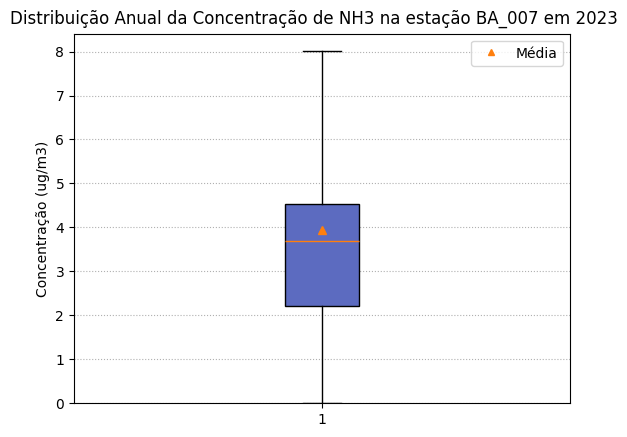

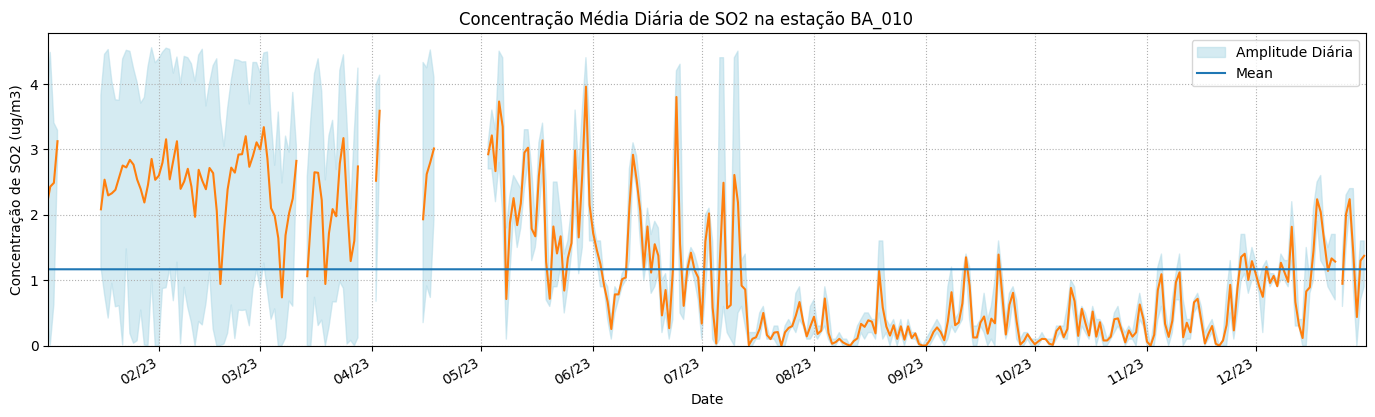

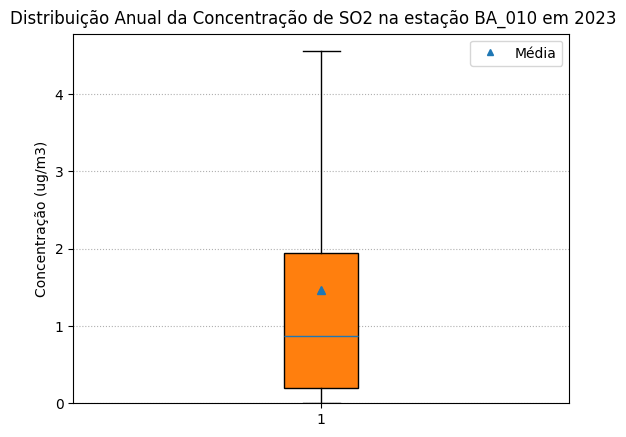

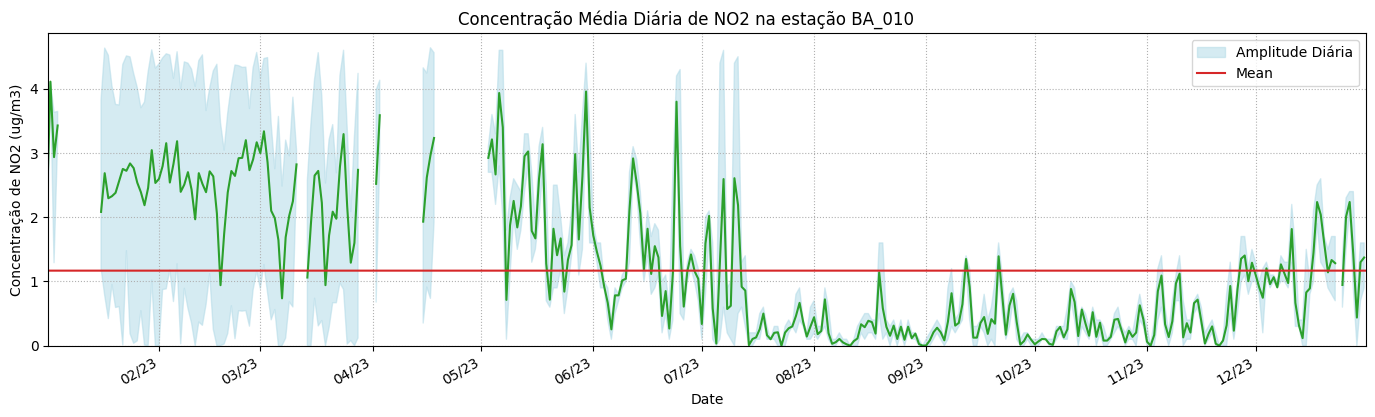

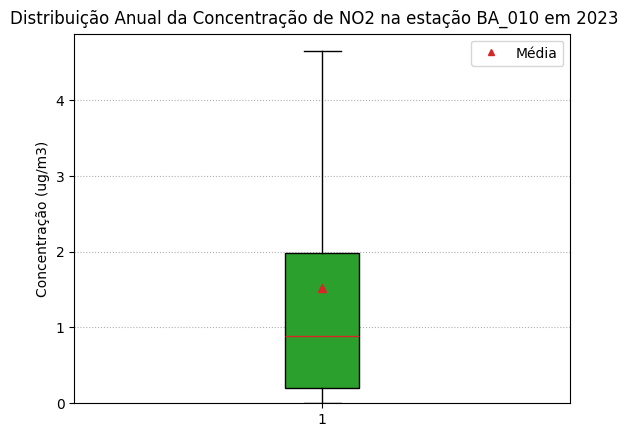

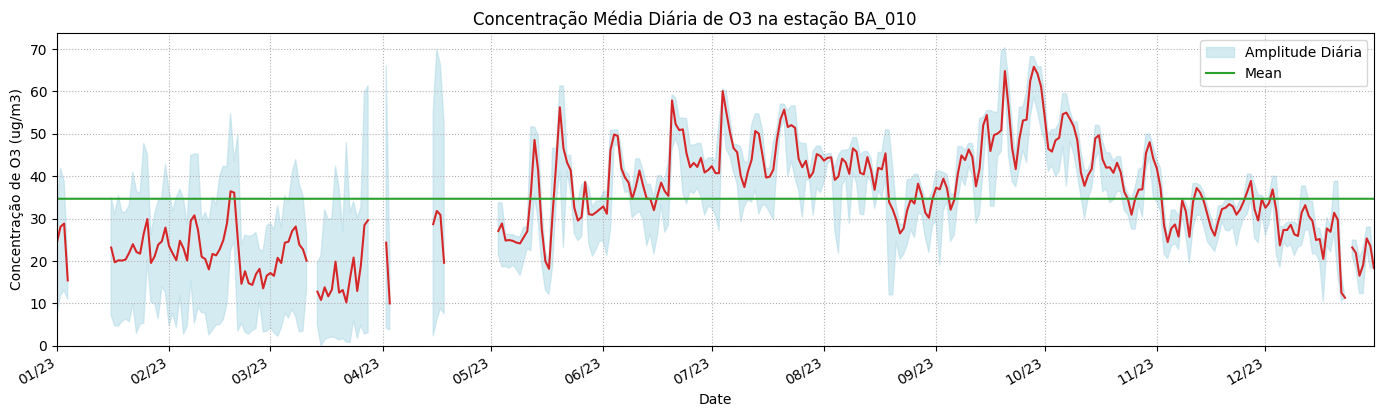

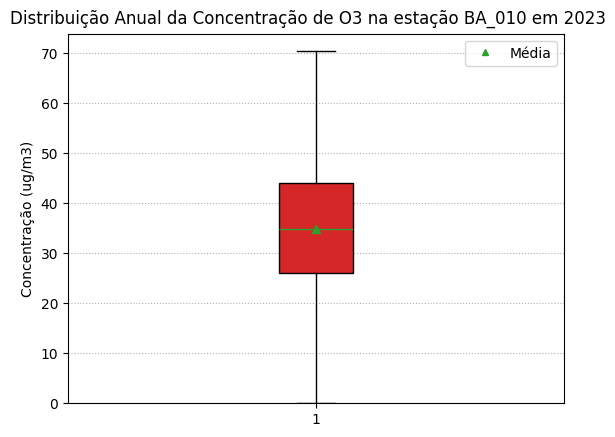

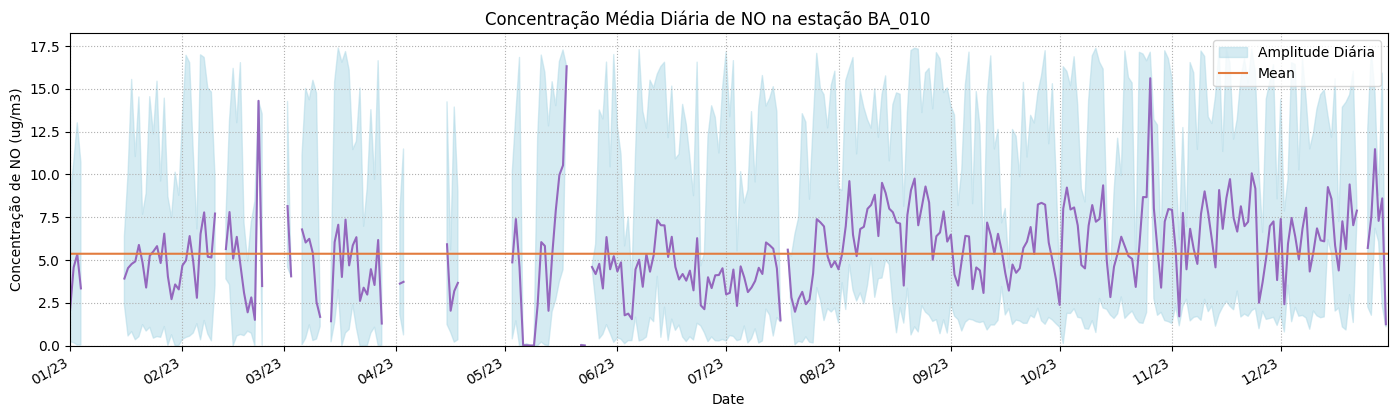

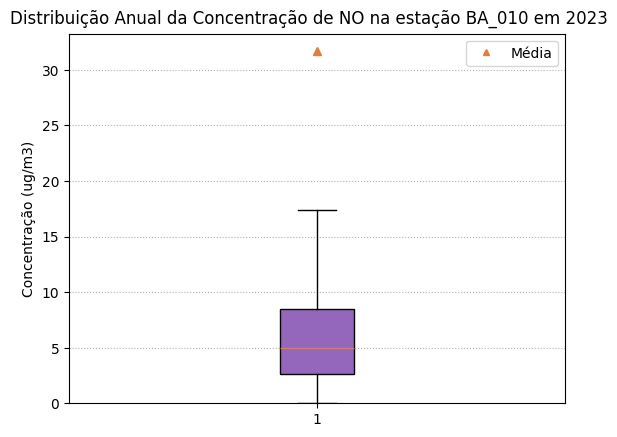

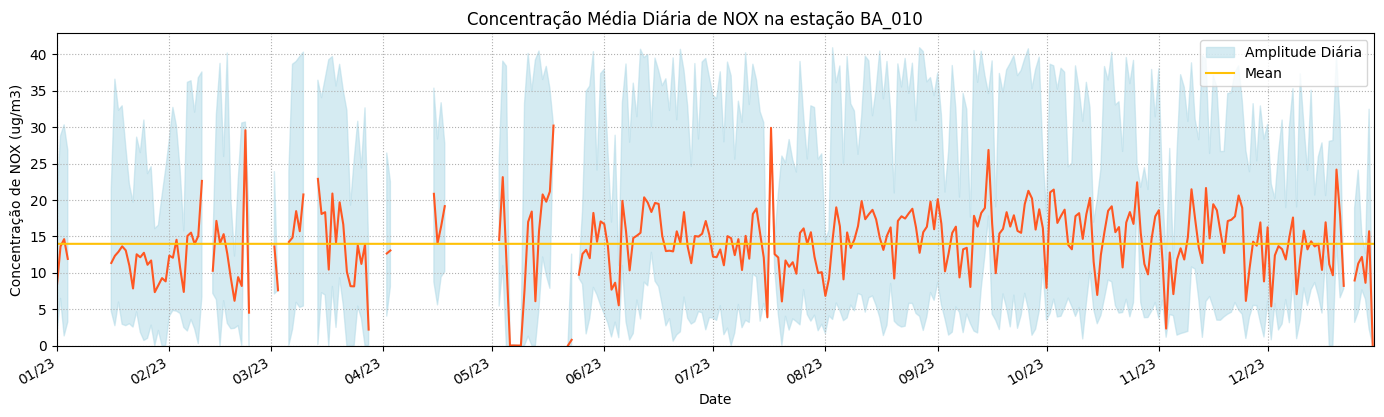

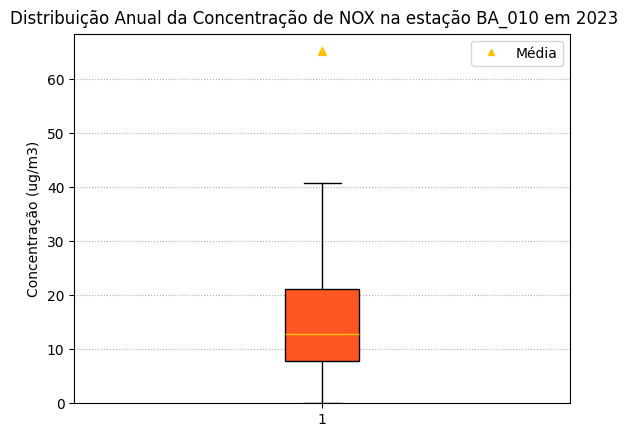

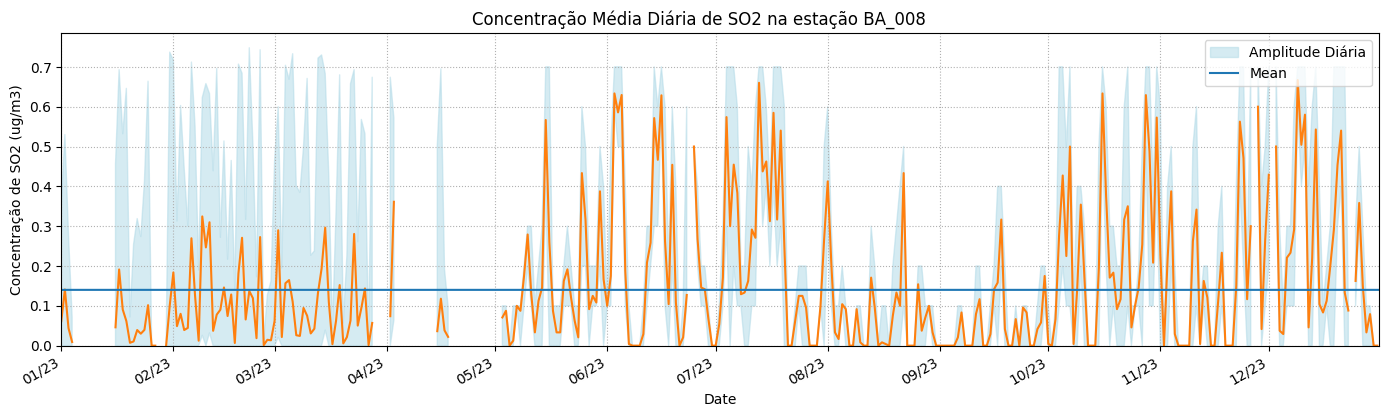

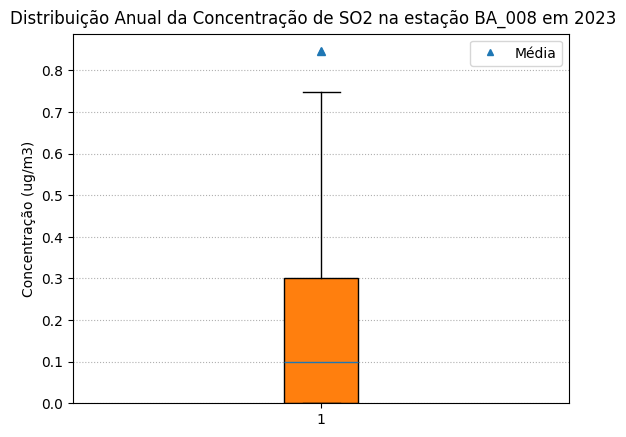

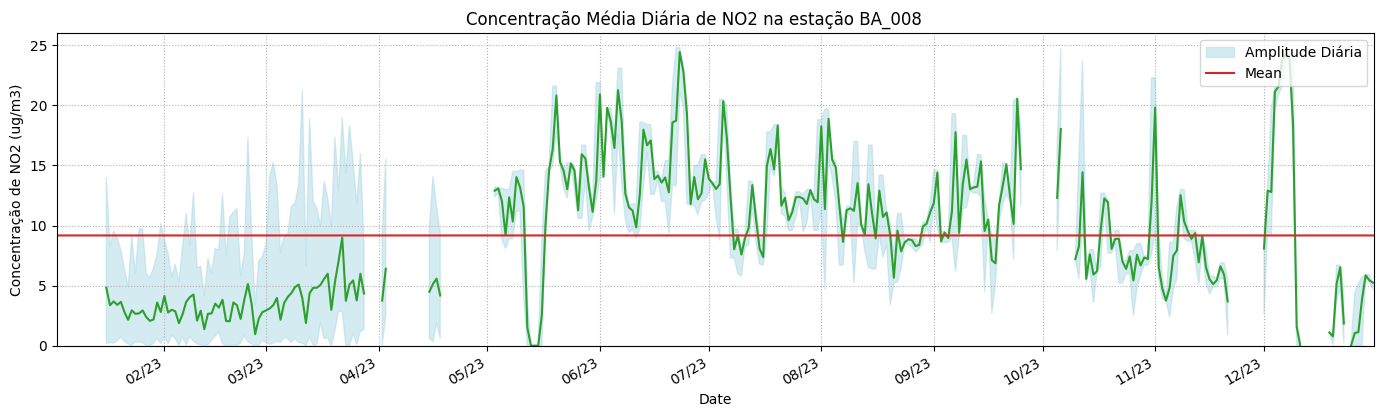

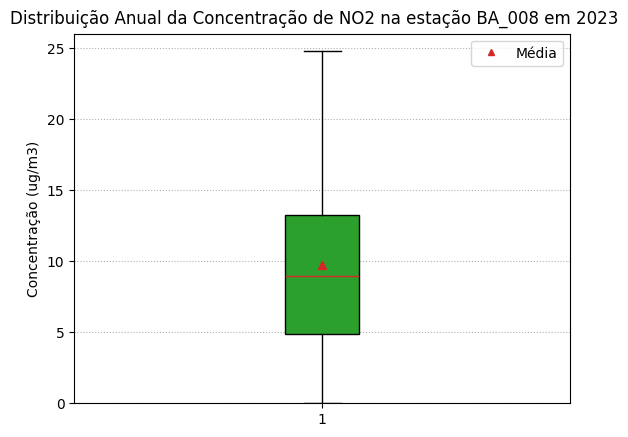

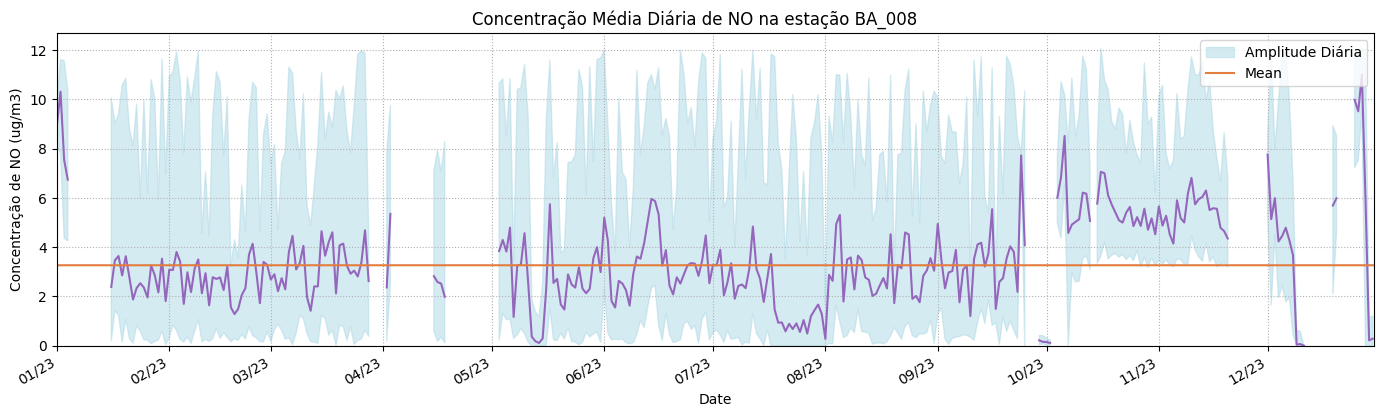

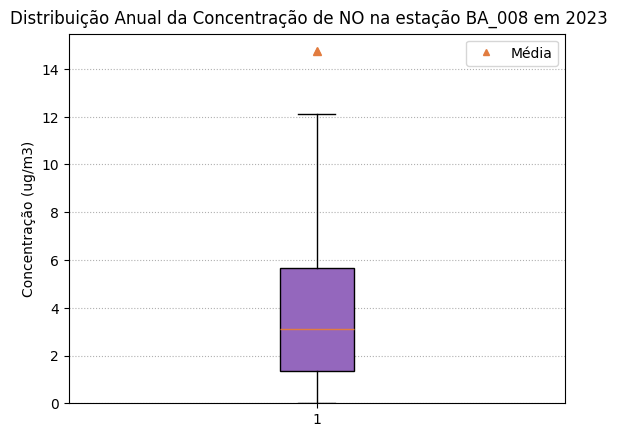

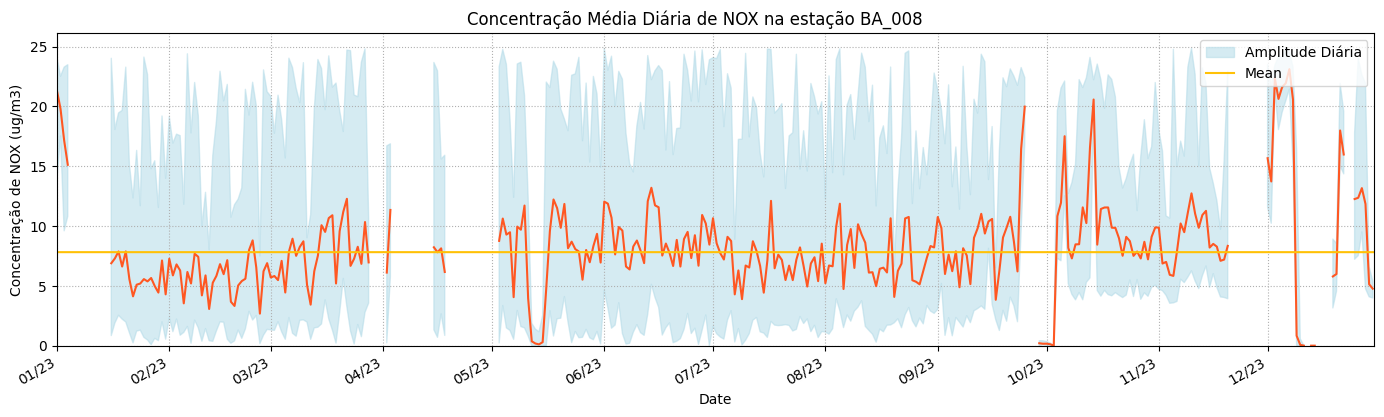

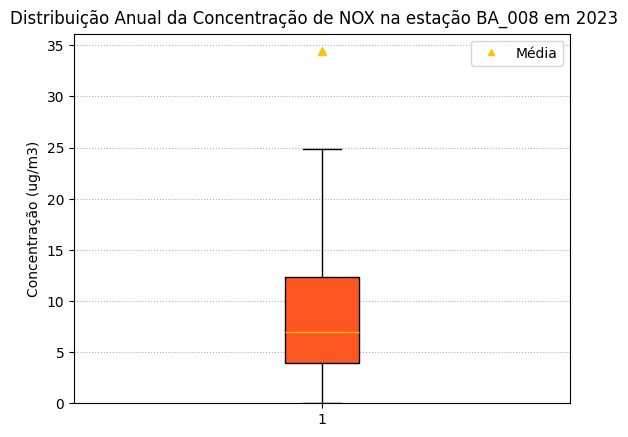

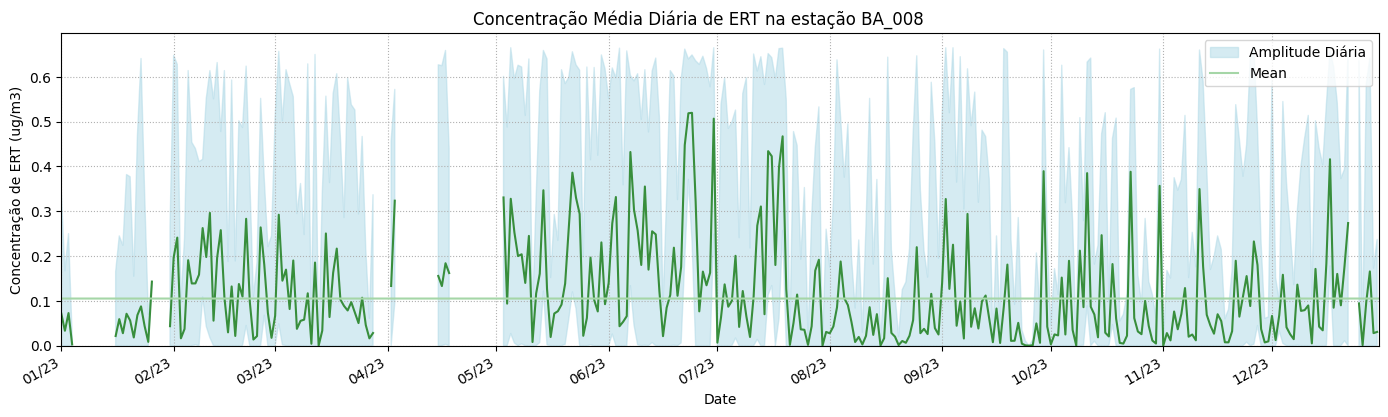

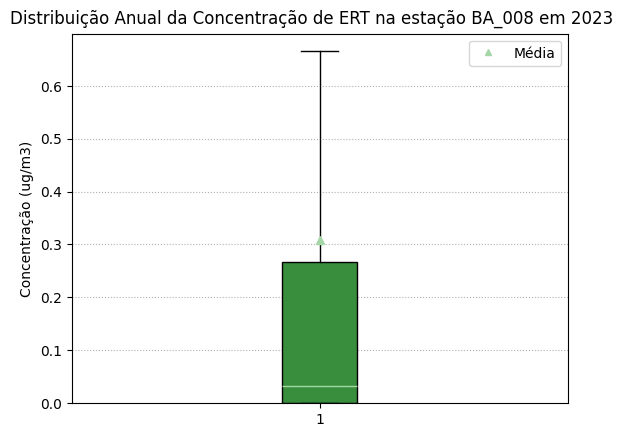

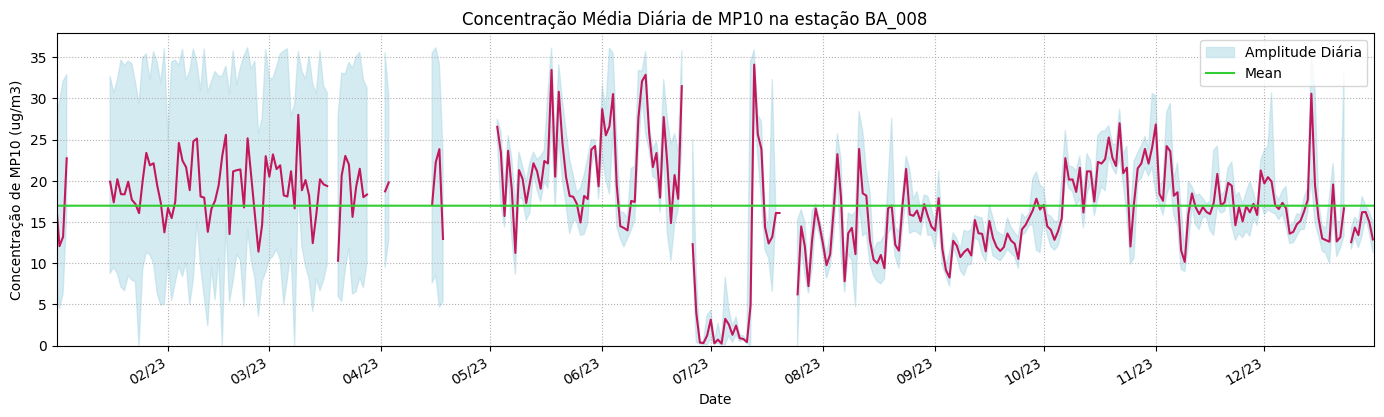

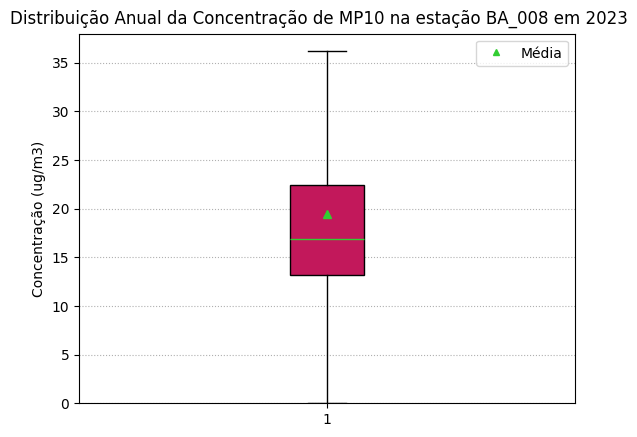

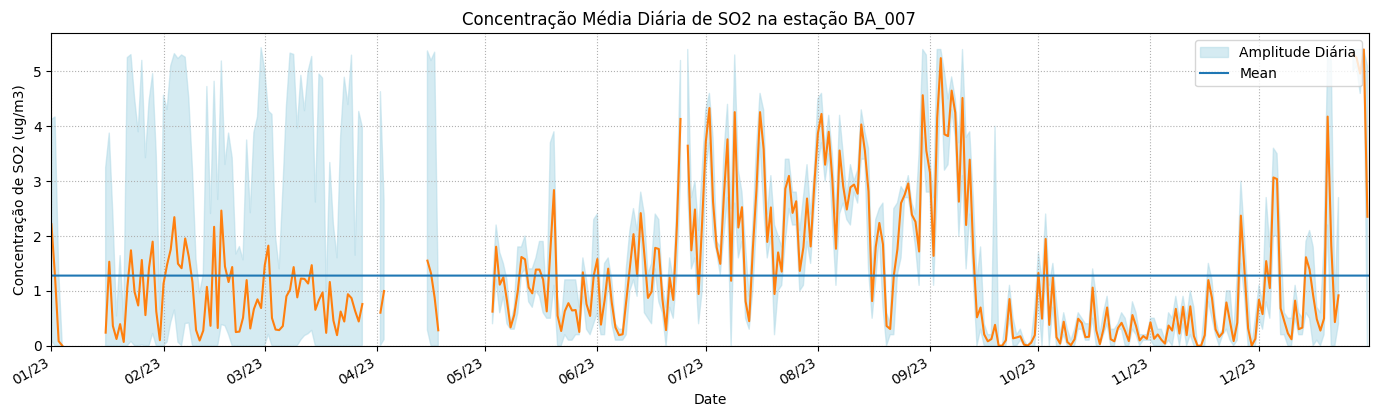

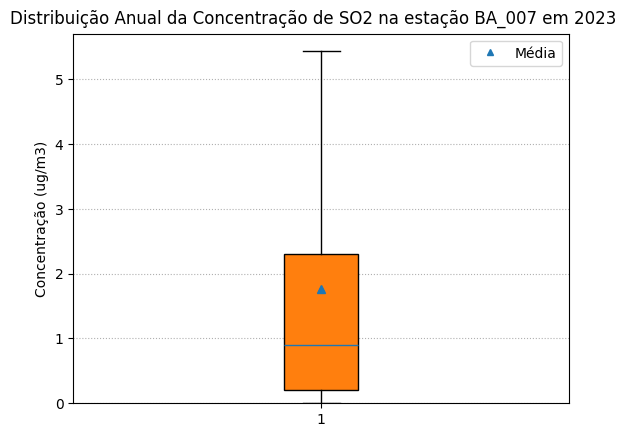

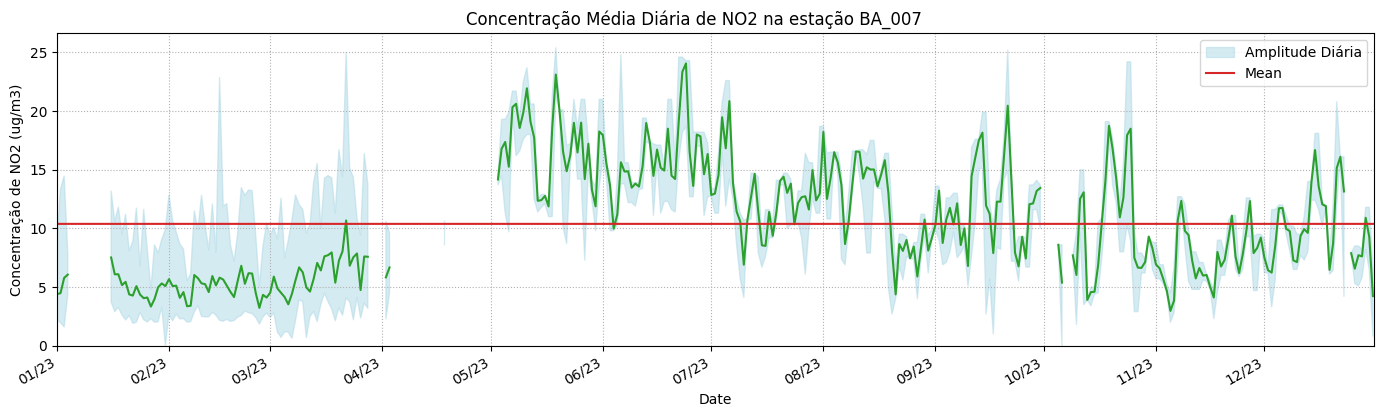

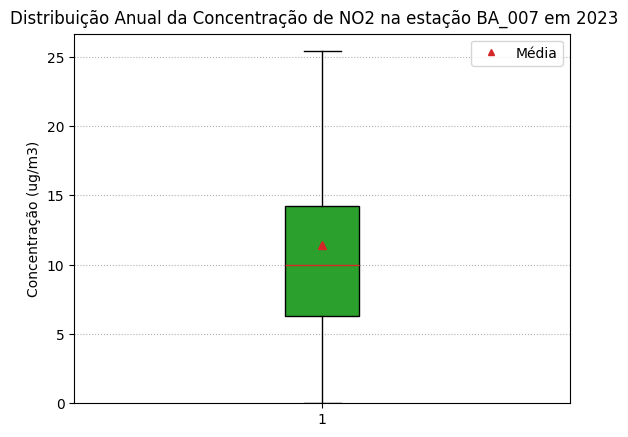

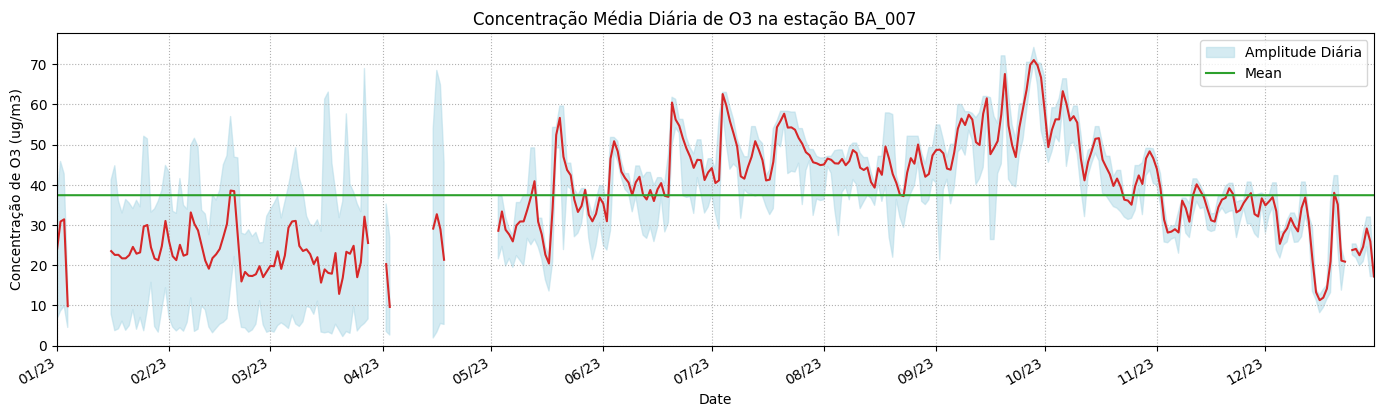

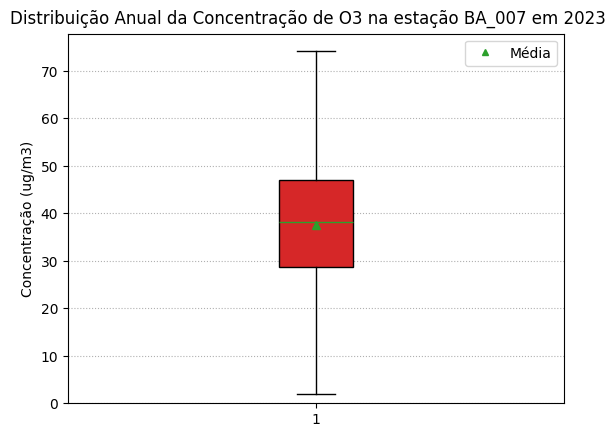

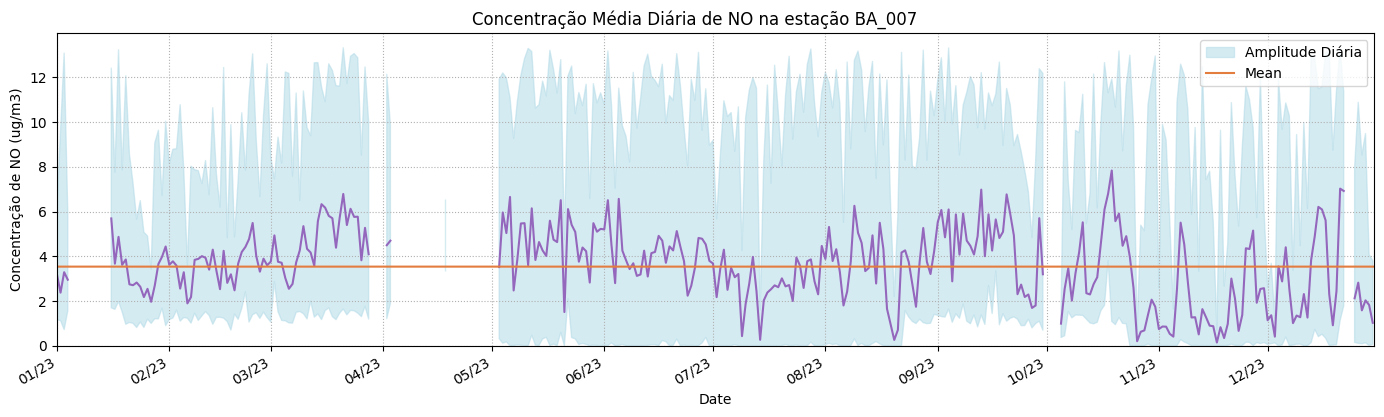

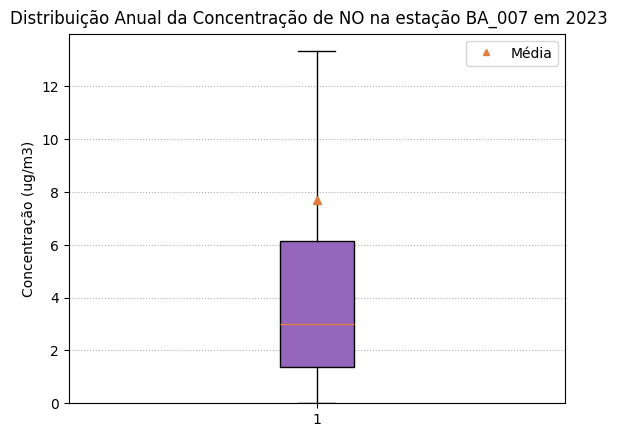

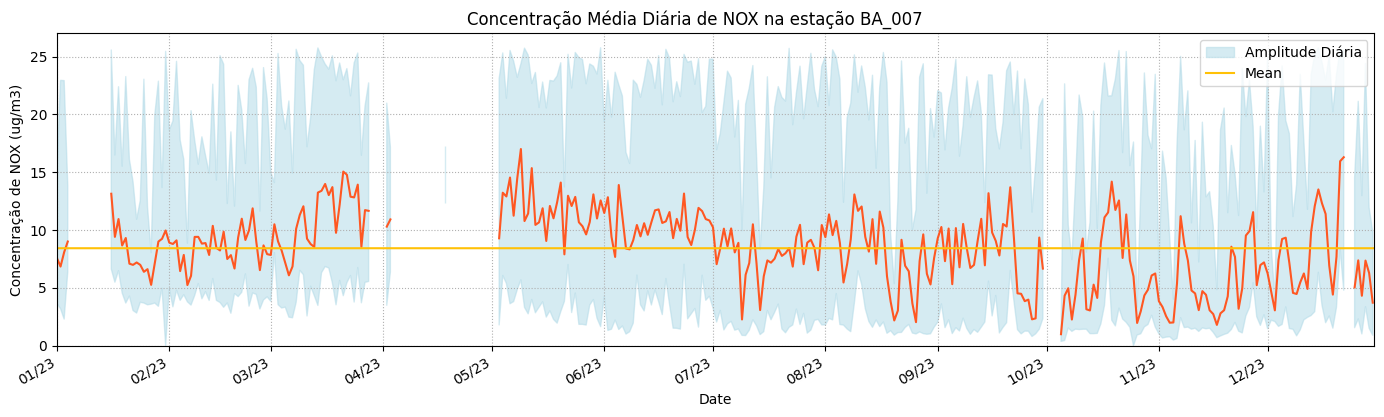

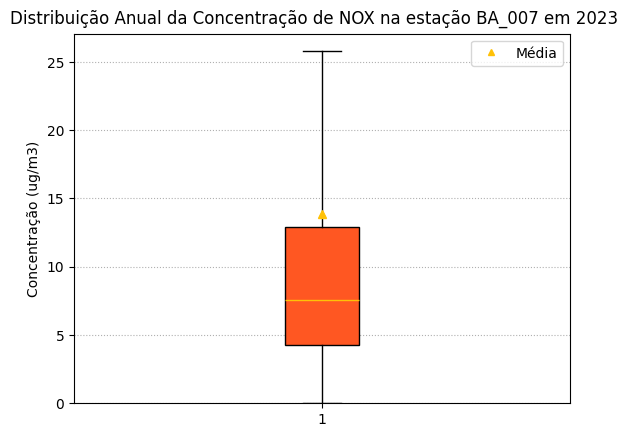

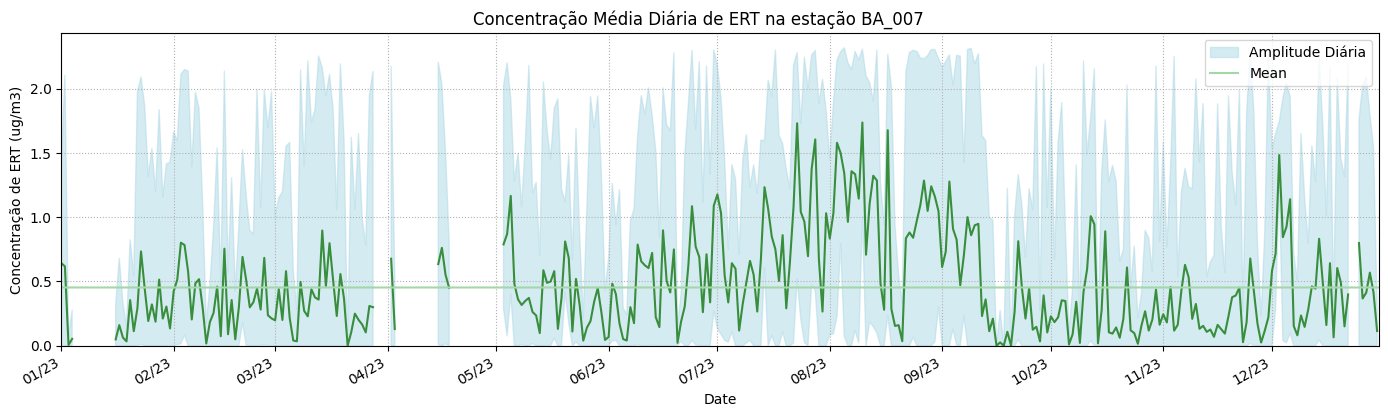

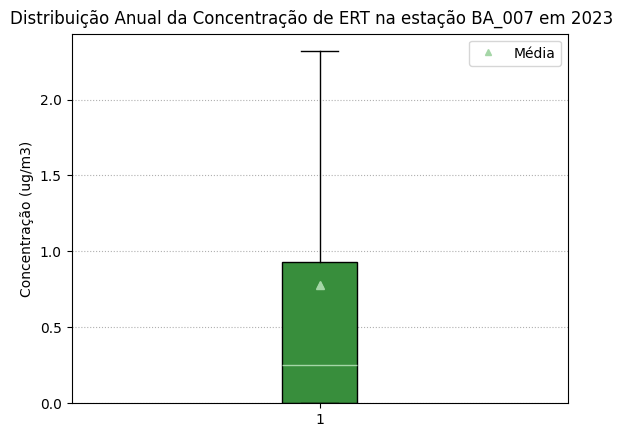

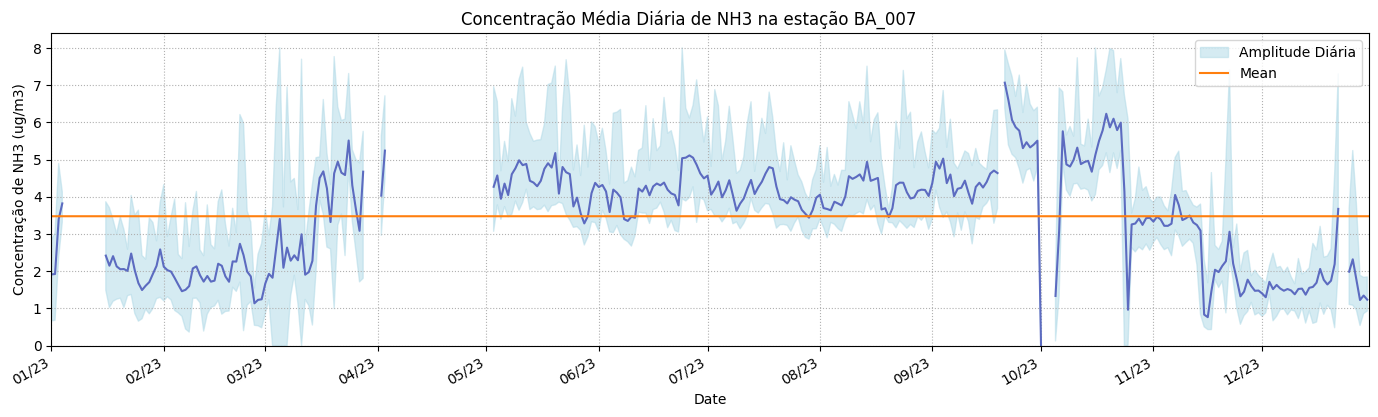

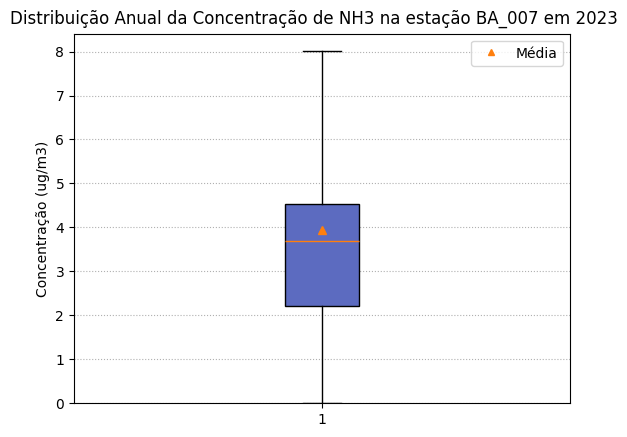

In [71]:
statisticsAndFigures_daily('BA_2023.csv')



## Estatísticas e Figuras divididas por HORA

In [5]:
def statisticsAndFigures_hourly(data):
    import os
    import scipy
    import numpy as np
    import pandas as pd
    import pymannkendall as mk
    from datetime import datetime
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.patches as mpatches

    # Extraindo o diretório que estamos trabalhando
    cwd = os.getcwd()
        
    # Estabelecendo a pasta de dados que quero utilizar
    dataPath = os.path.dirname(cwd) + r'\ENS410064\2024\dados_entrada\dados_T1'
    
    # Estabelecendo a pasta de outputs
    outputsPath = os.path.dirname(cwd) + r'\ENS410064\2024\outputs'
   
    # Estabelecendo pasta de de figuras
    figsPath = os.path.dirname(cwd) + r'\ENS410064\2024\figuras'
    
    # Lendo o arquivo 
    df = pd.read_csv(dataPath + '\\' + data, sep=';')

    # Criando listas de estações e poluentes para iterar sobre o dataframe todo
    stations = df['Codigo'].unique()
    print(stations)
    
    pollutants = df['Poluente'].unique()
    print(pollutants)
    
    units = dict(zip(df['Poluente'], df['Unidade']))
    print(units)

    colors_01 = [
    "#1f77b4",  # azul
    "#ff7f0e",  # laranja
    "#2ca02c",  # verde
    "#d62728",  # vermelho
    "#9467bd",  # roxo
    "#FF5722",  # laranja escuro
    "#388E3C",  # verde escuro
    "#C2185B",  # rosa escuro
    "#5C6BC0",  # azul escuro
    ]

    colors_02 = [
    "#FF7F0E",  # laranja
    "#1f77b4",  # azul
    "#d62728",  # vermelho
    "#2ca02c",  # verde
    "#e27c3f",  # laranja mais escuro
    "#FFC107",  # amarelo escuro
    "#A5D6A7",  # verde mais escuro
    "#32cd32",  # verde
    "#FF7F0E",  # laranja
    ]
    
    for st in stations:
        ii = 0
        for pl in pollutants:    
            ii+=1
            ### ORGANIZAÇÃO DOS DADOS
            # Filtrando dados válidos 
            serie = df.loc[
                (df['Poluente'] == str(pl) ) &
                (df['Codigo'] == str(st)) &
                (df['Valor'] >= 0)
            ]

            # Continuando os processos só se a estação tiver dado do poluente
            if not serie['Valor'].empty:   
                               
                # formatando data e adicionando ao índice
                serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora'], x['Minuto']), axis=1)
        
                # Colocando a coluna 'Date' como índice
                serie = serie.set_index('Date')
        
                # Selecionando somente os dados importantes para minha análise
                serie = serie[['Valor', 'Unidade','Tipo', 'Testacao']]
        
                #---------------------------------------------------------------
                ### CALCULANDO E EXPORTANDO ESTATÍSTICAS
                
                # Criar cópia antes de tirar os outliers, transformando em série horária para plotar
                serie_hourly = serie.copy()
                serie_hourly['Hora'] = serie_hourly.index.hour
                serie_hourly_toplot = serie_hourly.groupby("Hora")['Valor']
                
                # Tirar os outliers da série de dados
                Q1 = serie['Valor'].quantile(0.25)
                Q3 = serie['Valor'].quantile(0.75)
                IQR = Q3 - Q1    #IQR is interquartile range. 
                
                filtro = (serie['Valor'] >= Q1 - 1.5 * IQR) & (serie['Valor'] <= Q3 + 1.5 *IQR)
                serie = serie.loc[filtro]
                
                # Transformando em série horária para tirar as estatísticas por hora
                serie_hourly = serie.copy()
                serie_hourly['Hora'] = serie_hourly.index.hour
                hourly_statistics = serie_hourly.describe()

                # Teste de Kruskal Wallis (Sazonalidade)
                res=[]
                for i in serie_hourly.index.hour.unique():
                    res.append(serie_hourly[serie_hourly['Hora'] == i]['Valor'].values)
                if len(res)>=2:
                    result = scipy.stats.kruskal(*res)
                
                kruskal_df = pd.DataFrame({'Statistics': [result.statistic],
                                          "p-value": [result.pvalue]
                                          })
                
                # Criando a pasta dos outputs
                os.makedirs(os.path.dirname(cwd) + '\\ENS410064\\2024\\outputs', exist_ok=True)

                # Criar .csv com as estatísticas horárias em uma pasta de outputs
                hourly_statistics.to_csv(outputsPath + "\\" + st + '_' + pl + "_hourly_statistics" + '.csv')
                
                #---------------------------------------------------------------
                ### FIGURAS
                # Criando a pasta das figuras
                os.makedirs(os.path.dirname(cwd) + '\\ENS410064\\2024\\figuras\\' + st, exist_ok=True)

                # Criando boxplot horário para a estação st e poluente pl específicos      
                fig, ax = plt.subplots(figsize=(12,6))
                bp = ax.boxplot(serie_hourly_toplot.apply(list),
                                showmeans=True,
                                showfliers=False)
                # Mudar cores das caixas
                for box in bp['boxes']:
                    box.set_color(str(colors_01[ii]))
                for median in bp['medians']:
                    median.set_color(str(colors_02[ii]))
                
                # 
                for i in range(len(bp['means'])):
                    ax.plot(i + 1, bp['means'][i].get_ydata()[0], '^', markersize=5, label='Média' if i == 0 else "")
    
                plt.suptitle('Distribuição Horária da Concentração de '+ pl + " na estação " + st + " em 2023", y=0.93)
                ax.set_ylabel('Concentração ({})'.format(units[str(pl)]))
                ax.set_xlabel('Hora do Dia')
                plt.ylim(bottom = 0)
                ax.grid(which='major', axis='y', linestyle = ':')
                plt.legend()

                # Adicionando o resultado do teste Kruskal-Wallis no gráfico
                plt.figtext(0.132,
                            0.82,
                            f'Estatística de Kruskal-Wallis: {result.statistic:.2f}\np-valor: {result.pvalue:.2e}',
                            bbox=dict(facecolor='white', alpha=0.5))

                # Salvando o boxplot
                fig.savefig(os.path.dirname(cwd) +'\\ENS410064\\2024\\figuras\\'+ st + '\\hourly_boxplot_' + st + '_' + pl + '.png' )
    return fig

In [6]:
statisticsAndFigures_hourly('BA_2023.csv')

['BA_010' 'BA_008' 'BA_007']
['SO2' 'NO2' 'O3' 'NO' 'NOX' 'ERT' 'MP10' 'NH3']
{'SO2': 'ug/m3', 'NO2': 'ug/m3', 'O3': 'ug/m3', 'NO': 'ug/m3', 'NOX': 'ug/m3', 'ERT': 'ug/m3', 'MP10': 'ug/m3', 'NH3': 'ug/m3'}


KeyboardInterrupt: 



## Estatísticas e Figuras divididas por MÊS

In [51]:
def statisticsAndFigures_monthly(data):
    import os
    import scipy
    import numpy as np
    import pandas as pd
    import pymannkendall as mk
    from datetime import datetime
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.patches as mpatches

    # Extraindo o diretório que estamos trabalhando
    cwd = os.getcwd()
        
    # Estabelecendo a pasta de dados que quero utilizar
    dataPath = os.path.dirname(cwd) + r'\ENS410064\2024\dados_entrada\dados_T1'
    print('Diretório de dados: '+ dataPath)
    
    # Estabelecendo a pasta de outputs
    outputsPath = os.path.dirname(cwd) + r'\ENS410064\2024\outputs'
    print('Diretório de outputs: '+ outputsPath)
    
    # Estabelecendo pasta de trabalho
    figsPath = os.path.dirname(cwd) + r'\ENS410064\2024\figuras'
    
    # Lendo o arquivo 
    df = pd.read_csv(dataPath + '\\' + data, sep=';')

    # Criando listas de estações e poluentes para iterar sobre o dataframe todo
    stations = df['Codigo'].unique()
    print(stations)
    
    pollutants = df['Poluente'].unique()
    print(pollutants)
    
    units = dict(zip(df['Poluente'], df['Unidade']))
    print(units)

    colors_01 = [
    "#1f77b4",  # azul
    "#ff7f0e",  # laranja
    "#2ca02c",  # verde
    "#d62728",  # vermelho
    "#9467bd",  # roxo
    "#FF5722",  # laranja escuro
    "#388E3C",  # verde escuro
    "#C2185B",  # rosa escuro
    "#5C6BC0",  # azul escuro
    ]

    colors_02 = [
    "#FF7F0E",  # laranja
    "#1f77b4",  # azul
    "#d62728",  # vermelho
    "#2ca02c",  # verde
    "#e27c3f",  # laranja mais escuro
    "#FFC107",  # amarelo escuro
    "#A5D6A7",  # verde mais escuro
    "#D81B60",  # rosa
    "#FF7F0E",  # laranja
    ]
    
    for st in stations:
        ii=0
        for pl in pollutants:    
            ii+=1
            ### ORGANIZAÇÃO DOS DADOS
            # Filtrando dados válidos 
            serie = df.loc[
                (df['Poluente'] == str(pl) ) &
                (df['Codigo'] == str(st)) &
                (df['Valor'] >= 0)
            ]

            # Continuando os processos só se a estação tiver dado do poluente
            if not serie['Valor'].empty:   
                               
                # formatando data e adicionando ao índice
                serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora'], x['Minuto']), axis=1)
        
                # Colocando a coluna 'Date' como índice
                serie = serie.set_index('Date')
        
                # Selecionando somente os dados importantes para minha análise
                serie = serie[['Valor', 'Unidade','Tipo', 'Testacao']]
       
                #---------------------------------------------------------------
                ### CALCULANDO E EXPORTANDO ESTATÍSTICAS
              
                # Criar cópia antes de tirar os outliers, transformando em série mensal para plotar
                serie_monthly = serie.copy()
                serie_monthly['Mes'] = serie_monthly.index.month
                serie_monthly_toplot = serie_monthly.groupby("Mes")['Valor']
                                
                # Tirar os outliers da série de dados
                Q1 = serie['Valor'].quantile(0.25)
                Q3 = serie['Valor'].quantile(0.75)
                IQR = Q3 - Q1    #IQR is interquartile range. 
                
                filtro = (serie['Valor'] >= Q1 - 1.5 * IQR) & (serie['Valor'] <= Q3 + 1.5 *IQR)
                serie = serie.loc[filtro]
                
                # Transformando em série mensal para tirar as estatísticas por mês
                serie_monthly = serie.copy()
                serie_monthly['Mes'] = serie_monthly.index.month
                serie_monthly = serie_monthly.groupby("Mes")['Valor']
                monthly_statistics = serie_monthly.describe()

                # Criando a pasta dos outputs
                os.makedirs(os.path.dirname(cwd) + '\\ENS410064\\2024\\outputs', exist_ok=True)

                # Criar .csv com as estatísticas horárias em uma pasta de outputs
                monthly_statistics.to_csv(outputsPath + "\\" + st + '_' + pl + "_monthly_statistics" + '.csv')

                #---------------------------------------------------------------
                ### FIGURAS
                # Criando a pasta das figuras
                os.makedirs(os.path.dirname(cwd) + '\\ENS410064\\2024\\figuras\\' + st, exist_ok=True)

                # Criando boxplot mensal para a estação st e poluente pl específicos      
                fig, ax = plt.subplots(figsize=(12,6))
                bp = ax.boxplot(serie_monthly_toplot.apply(list), 
                                showmeans=True,
                                showfliers=False)
                for i in range(len(bp['means'])):
                        ax.plot(i + 1, bp['means'][i].get_ydata()[0], '^', color=colors_02[ii], markersize=5, label='Média' if i == 0 else "")
                
                plt.suptitle('Distribuição Mensal das Concentrações de '+ pl + " na estação " + st + " em 2023", y=0.93)
                ax.set_ylabel('Concentração ({})'.format(units[str(pl)]))
                ax.set_xlabel('Mês')
                months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
                ax.set_xticklabels(months)
                plt.ylim(bottom = 0)
                ax.grid(which='major', axis='y', linestyle = ':')

                # Salvando o boxplot
                fig.savefig(os.path.dirname(cwd) +'\\ENS410064\\2024\\figuras\\'+ st + '\\monthly_boxplot_' + st + '_' + pl + '.png' )
    return fig

Diretório de dados: C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\dados_entrada\dados_T1
Diretório de outputs: C:\Users\bruno\Desktop\UFSC\2024.2\ENS410064\2024\outputs
['BA_010' 'BA_008' 'BA_007']
['SO2' 'NO2' 'O3' 'NO' 'NOX' 'ERT' 'MP10' 'NH3']
{'SO2': 'ug/m3', 'NO2': 'ug/m3', 'O3': 'ug/m3', 'NO': 'ug/m3', 'NOX': 'ug/m3', 'ERT': 'ug/m3', 'MP10': 'ug/m3', 'NH3': 'ug/m3'}


C:\Users\bruno\AppData\Local\Temp\ipykernel_16696\1667167184.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora'], x['Minuto']), axis=1)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16696\1667167184.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora

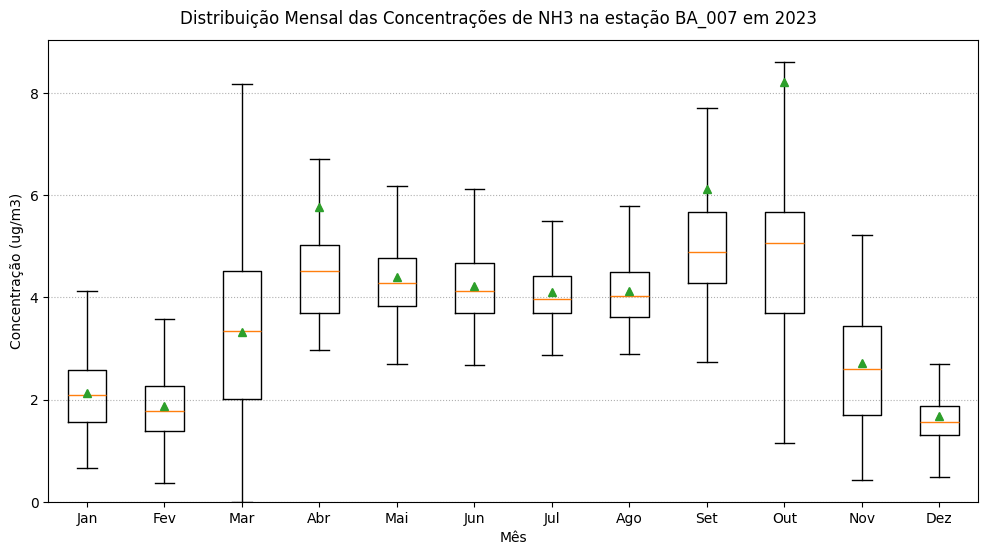

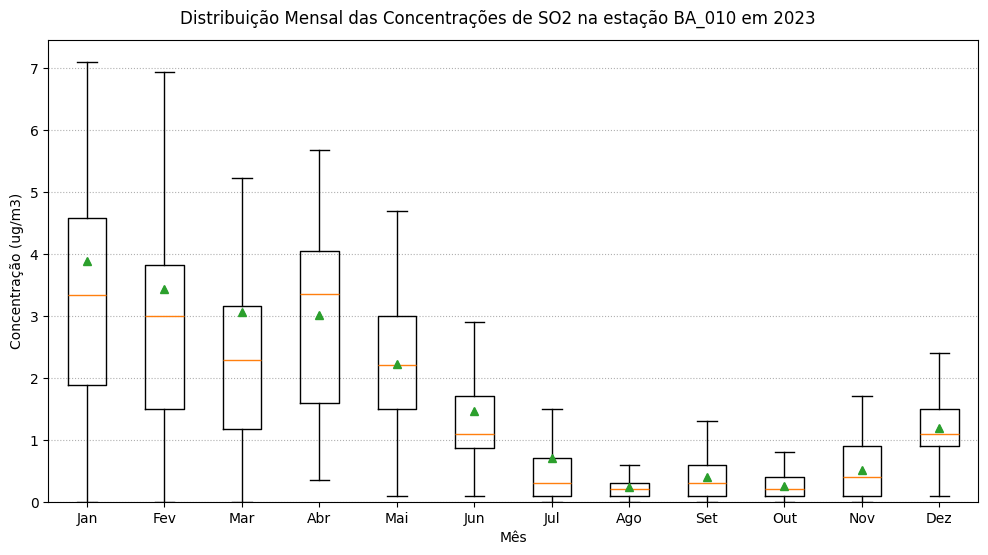

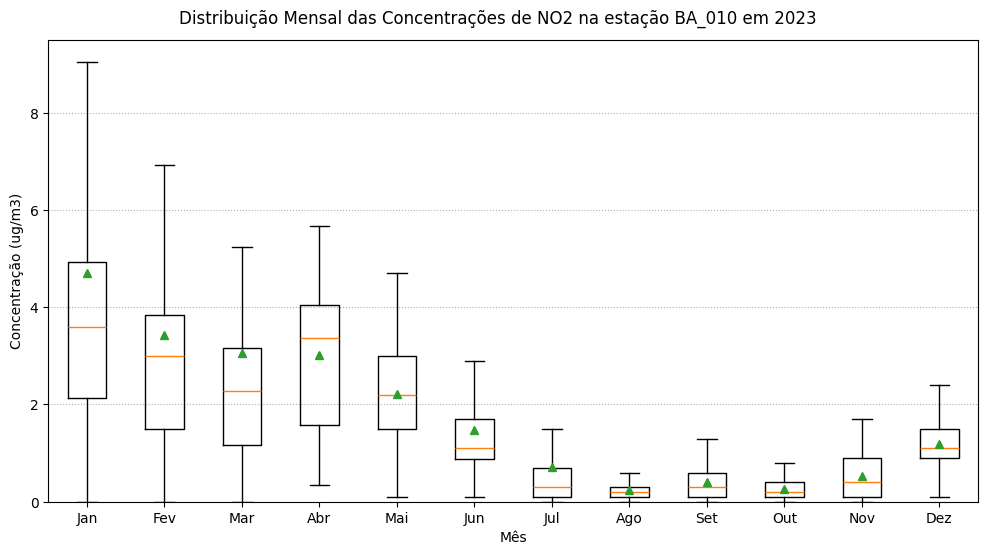

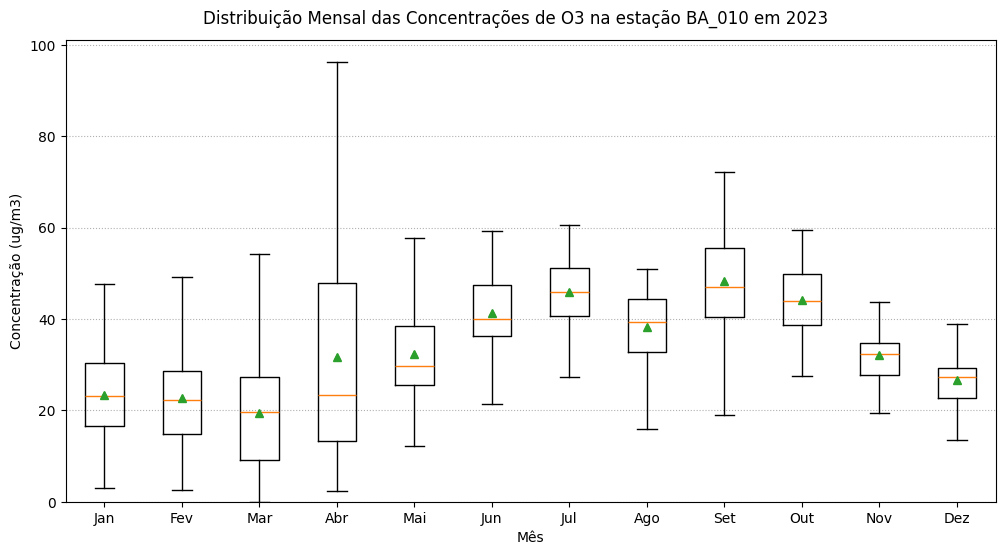

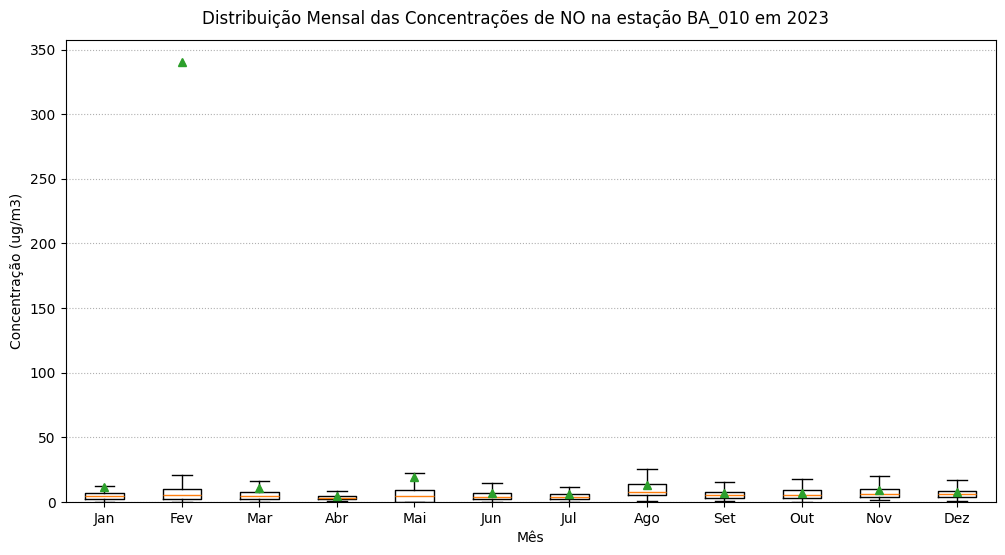

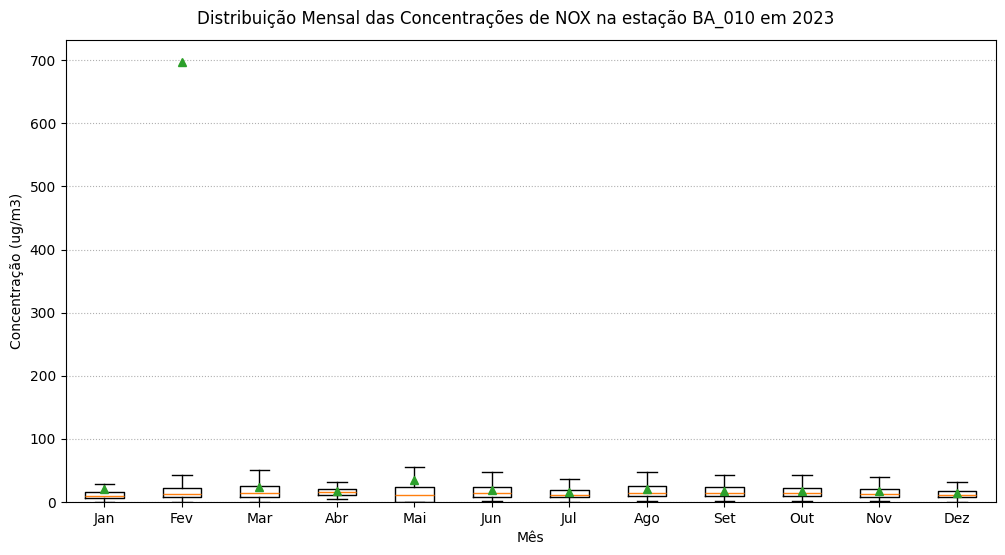

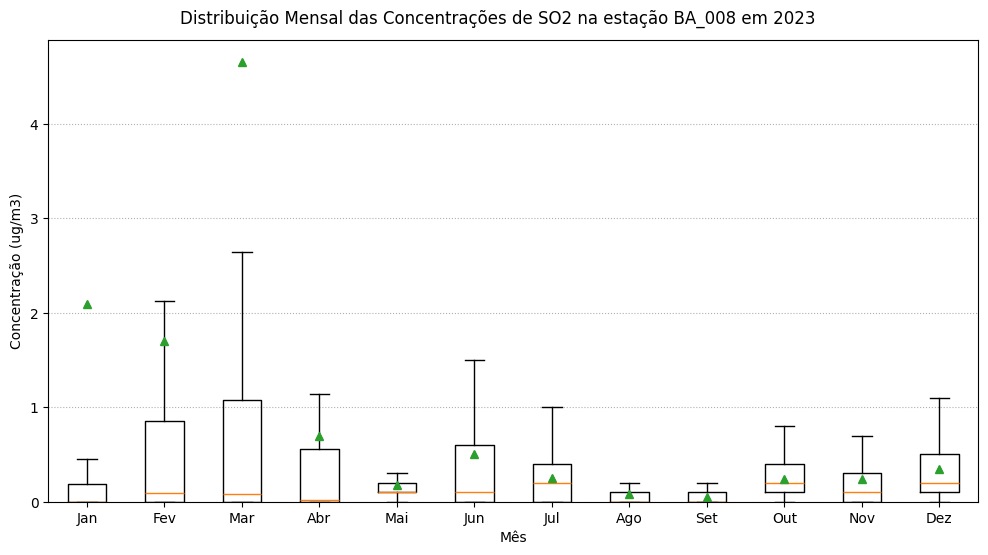

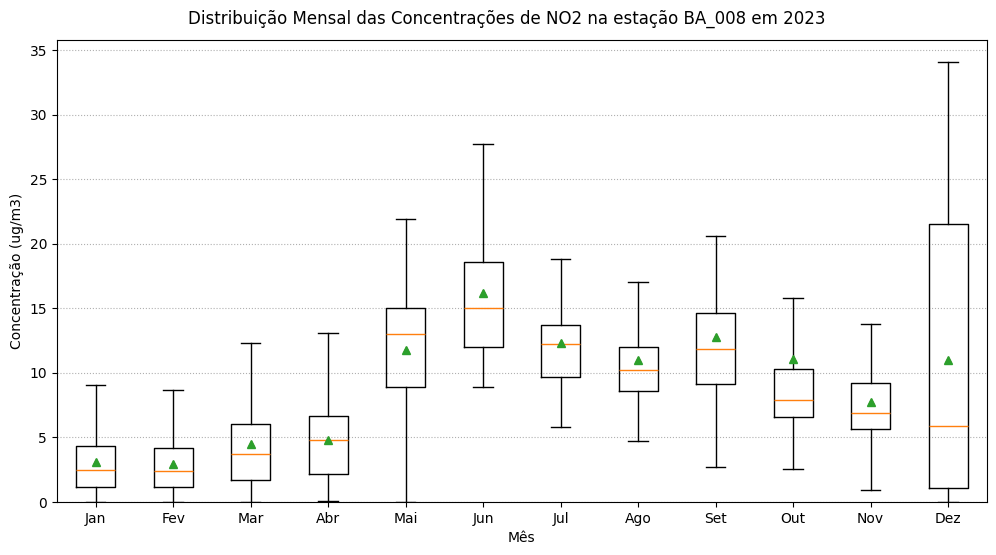

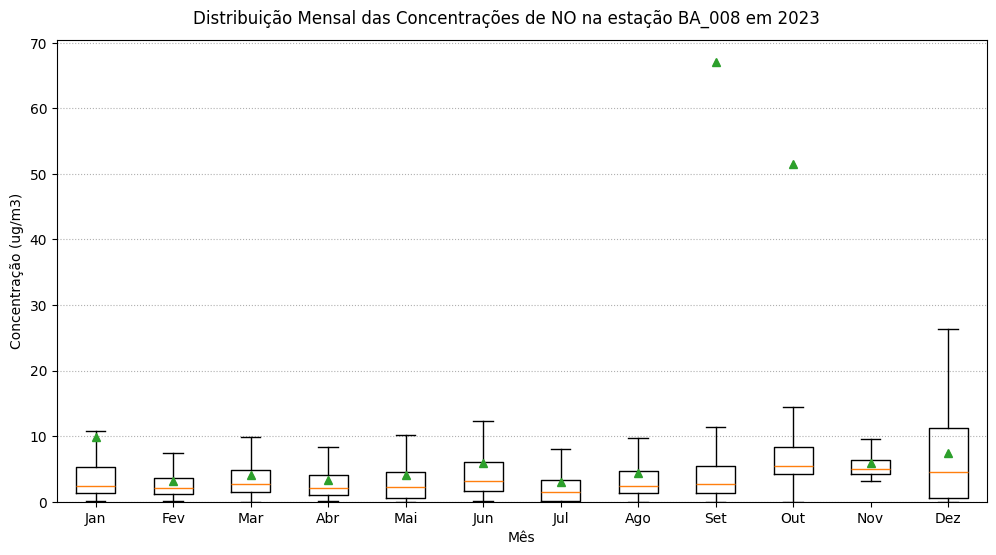

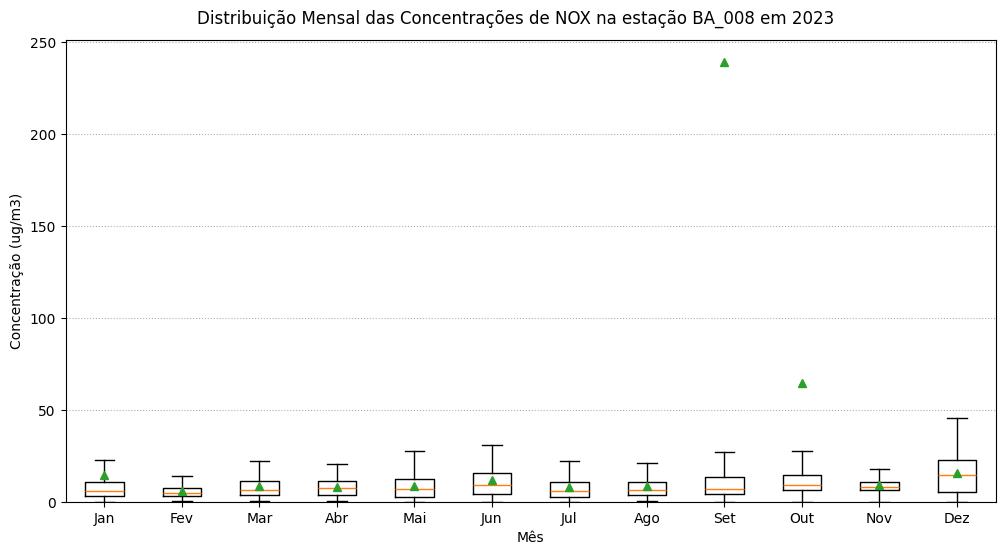

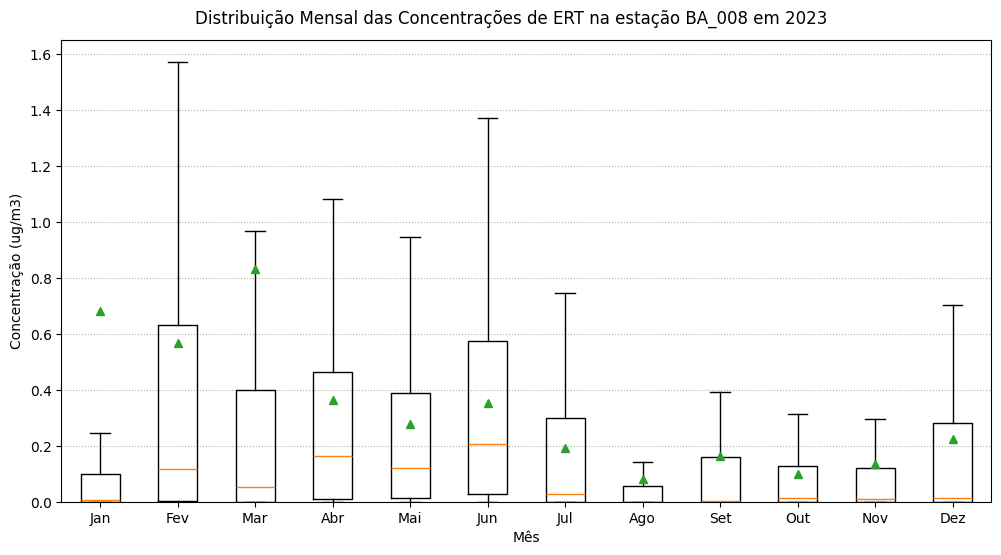

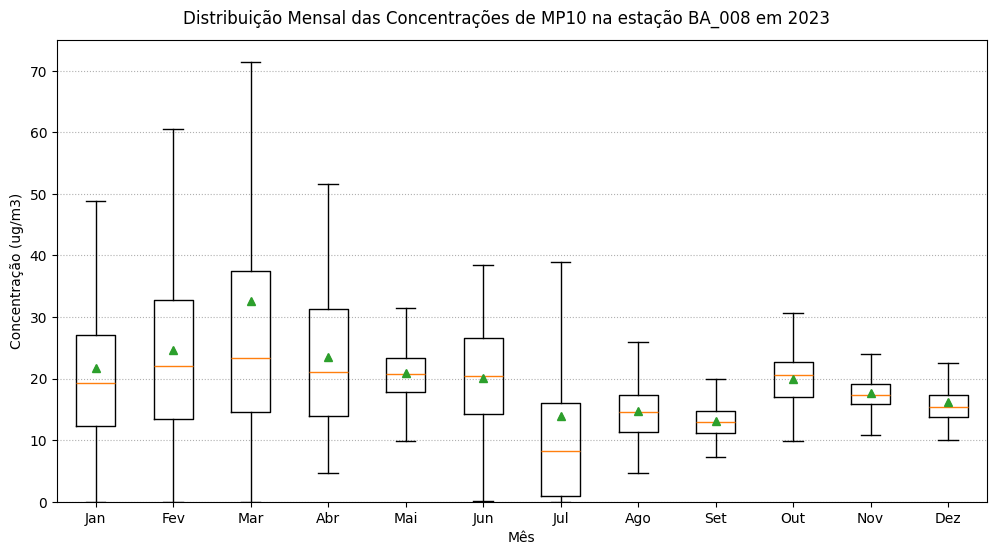

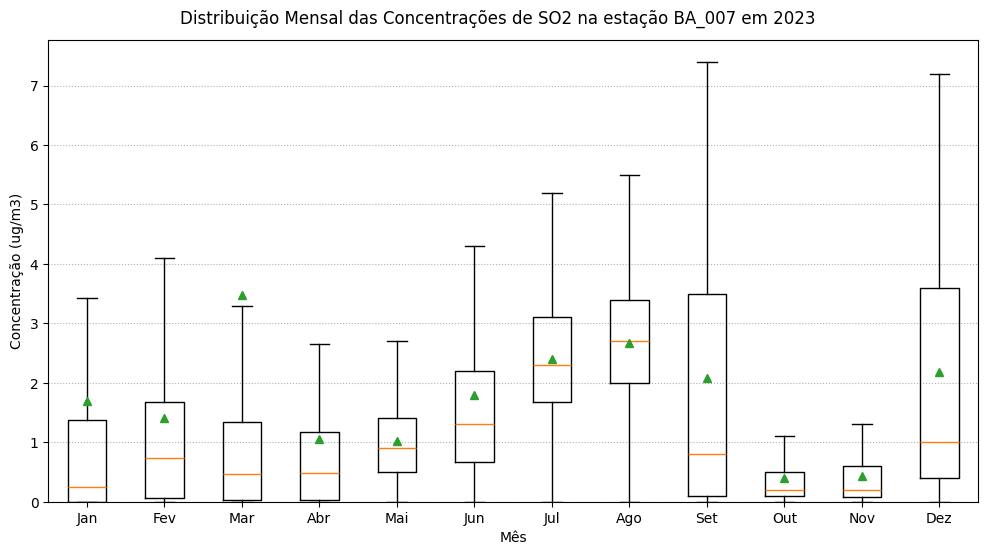

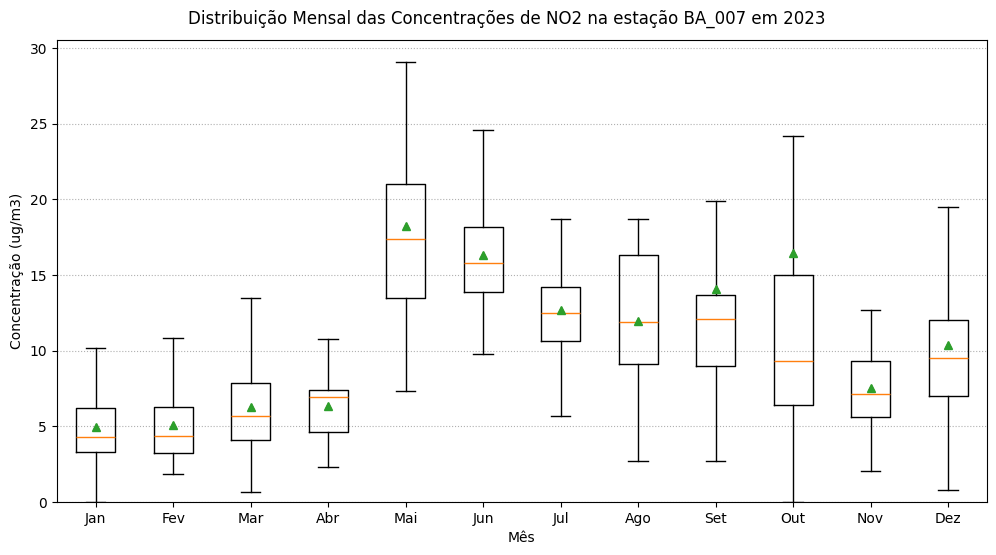

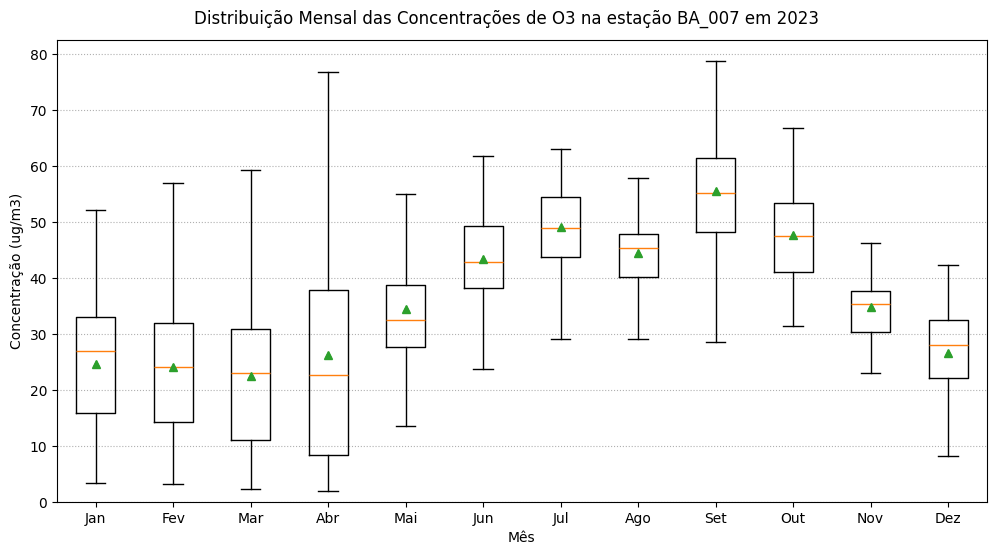

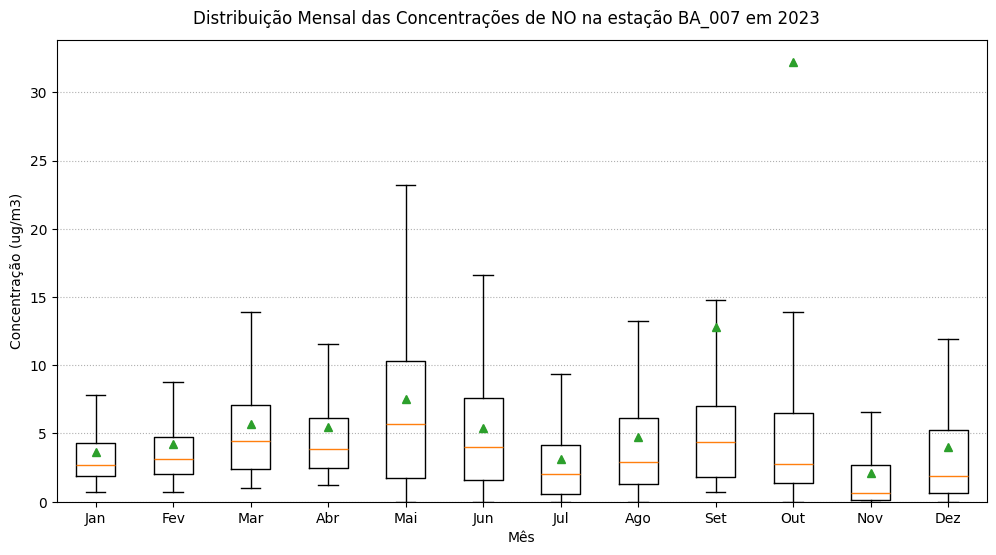

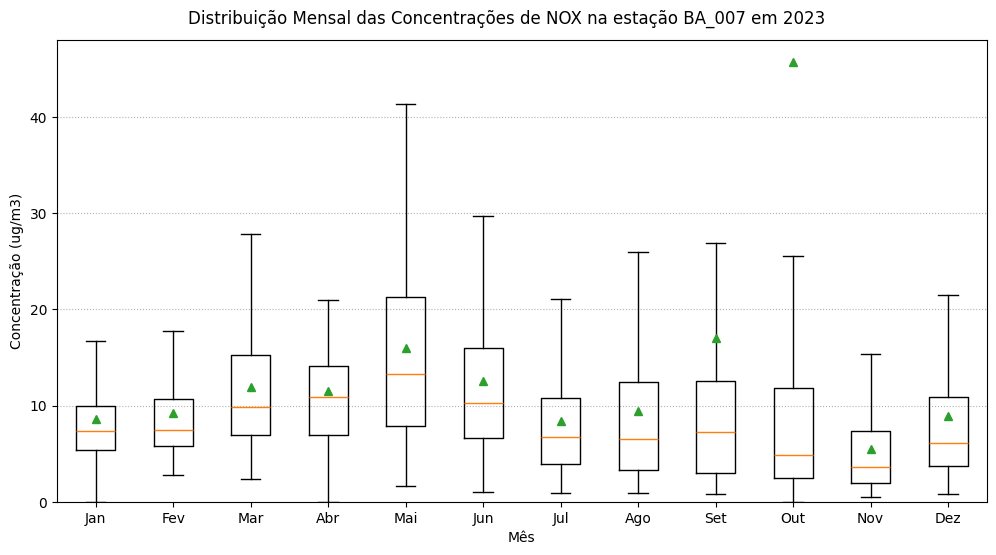

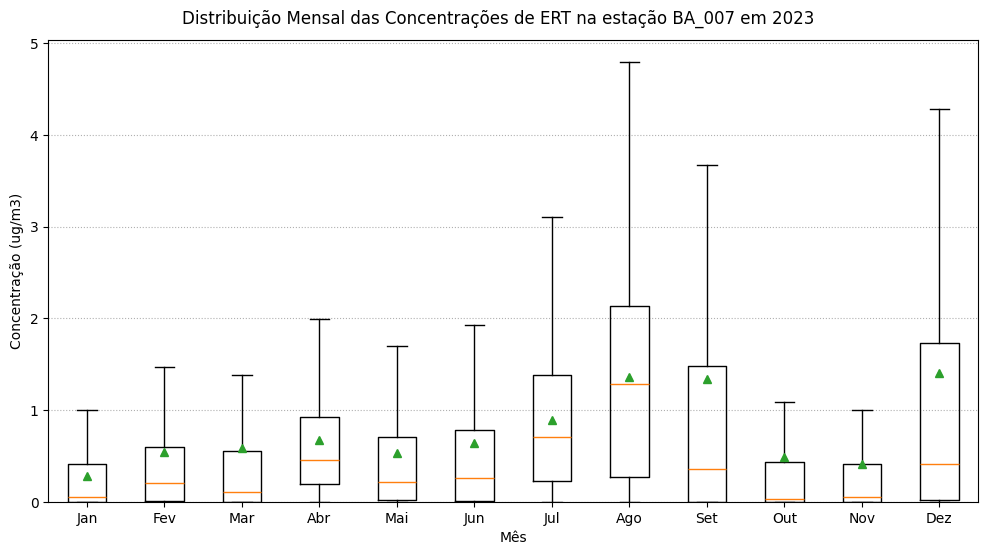

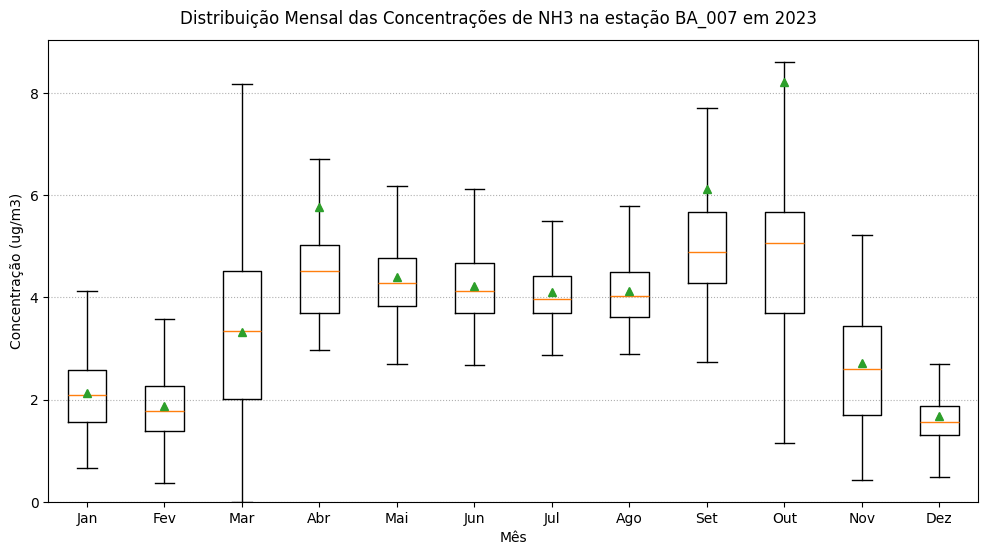

In [52]:
statisticsAndFigures_monthly("BA_2023.csv")

## Estatísticas por Dia da semana

In [81]:
def statisticsAndFigures_weekday(data):
    import os
    import scipy
    import numpy as np
    import pandas as pd
    import pymannkendall as mk
    from datetime import datetime
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.patches as mpatches

    # Extraindo o diretório que estamos trabalhando
    cwd = os.getcwd()
        
    # Estabelecendo a pasta de dados que quero utilizar
    dataPath = os.path.dirname(cwd) + r'\ENS410064\2024\dados_entrada\dados_T1'
    
    # Estabelecendo a pasta de outputs
    outputsPath = os.path.dirname(cwd) + r'\ENS410064\2024\outputs'
   
    # Estabelecendo pasta de de figuras
    figsPath = os.path.dirname(cwd) + r'\ENS410064\2024\figuras'
    
    # Lendo o arquivo 
    df = pd.read_csv(dataPath + '\\' + data, sep=';')

    # Criando listas de estações e poluentes para iterar sobre o dataframe todo
    stations = df['Codigo'].unique()
    print(stations)
    
    pollutants = df['Poluente'].unique()
    print(pollutants)
    
    units = dict(zip(df['Poluente'], df['Unidade']))
    print(units)

    colors_01 = [
    "#1f77b4",  # azul
    "#ff7f0e",  # laranja
    "#2ca02c",  # verde
    "#d62728",  # vermelho
    "#9467bd",  # roxo
    "#FF5722",  # laranja escuro
    "#388E3C",  # verde escuro
    "#C2185B",  # rosa escuro
    "#5C6BC0",  # azul escuro
    ]

    colors_02 = [
    "#FF7F0E",  # laranja
    "#1f77b4",  # azul
    "#d62728",  # vermelho
    "#2ca02c",  # verde
    "#e27c3f",  # laranja mais escuro
    "#FFC107",  # amarelo escuro
    "#A5D6A7",  # verde mais escuro
    "#D81B60",  # rosa
    "#FF7F0E",  # laranja
    ]
   
    for st in stations:
        ii = 0
        for pl in pollutants:    
            ii+=1
            ### ORGANIZAÇÃO DOS DADOS
            # Filtrando dados válidos 
            serie = df.loc[
                (df['Poluente'] == str(pl) ) &
                (df['Codigo'] == str(st)) &
                (df['Valor'] >= 0)
            ]

            # Continuando os processos só se a estação tiver dado do poluente
            if not serie['Valor'].empty:   
                               
                # formatando data e adicionando ao índice
                serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora'], x['Minuto']), axis=1)
        
                # Colocando a coluna 'Date' como índice
                serie = serie.set_index('Date')
        
                # Selecionando somente os dados importantes para minha análise
                serie = serie[['Valor', 'Unidade','Tipo', 'Testacao']]
        
                #---------------------------------------------------------------
                ### CALCULANDO E EXPORTANDO ESTATÍSTICAS
                
                # Criar cópia antes de tirar os outliers, transformando em série horária para plotar
                serie_weekday = serie.copy()
                serie_weekday['Dia da Semana'] = serie_weekday.index.day_name(locale="pt_BR")
                serie_weekday_toplot = serie_weekday.groupby("Dia da Semana")['Valor']
                
                # Tirar os outliers da série de dados
                Q1 = serie['Valor'].quantile(0.25)
                Q3 = serie['Valor'].quantile(0.75)
                IQR = Q3 - Q1    #IQR is interquartile range. 
                
                filtro = (serie['Valor'] >= Q1 - 1.5 * IQR) & (serie['Valor'] <= Q3 + 1.5 *IQR)
                serie = serie.loc[filtro]

                               
                # Transformando em série de dia da semana para tirar as estatísticas por dia da semana
                serie_weekday = serie.copy()
                serie_weekday['Dia da Semana'] = serie_weekday.index.dayofweek
                weekday_statistics = serie_weekday.describe()
                
                # Teste de Kruskal Wallis (Sazonalidade)
                res=[]
                for i in serie_weekday.index.dayofweek.unique():
                    res.append(serie_weekday[serie_weekday['Dia da Semana'] == i]['Valor'].values)
                if len(res)>=2:
                    result = scipy.stats.kruskal(*res)
                
                kruskal_df = pd.DataFrame({'Statistics': [result.statistic],
                                          "p-value": [result.pvalue]
                                          })
               

                # Criando a pasta dos outputs
                os.makedirs(os.path.dirname(cwd) + '\\ENS410064\\2024\\outputs', exist_ok=True)

                # Criar .csv com as estatísticas horárias em uma pasta de outputs
                weekday_statistics.to_csv(outputsPath + "\\" + st + '_' + pl + "_weekday_statistics" + '.csv')
                
                #---------------------------------------------------------------
                ### FIGURAS
                # Criando a pasta das figuras
                os.makedirs(os.path.dirname(cwd) + '\\ENS410064\\2024\\figuras\\' + st, exist_ok=True)

                # Criando boxplot horário para a estação st e poluente pl específicos      
                fig, ax = plt.subplots(figsize=(12,6))
                bp = ax.boxplot(serie_weekday_toplot.apply(list), showfliers=False, showmeans=True)
                for box in bp['boxes']:
                    box.set_color(str(colors_01[ii]))
                for median in bp['medians']:
                    median.set_color(str(colors_02[ii]))
                for i in range(len(bp['means'])):
                    ax.plot(i + 1, bp['means'][i].get_ydata()[0], '^', markersize=5, label='Média' if i == 0 else "")
                    
                plt.suptitle('Distribuição da Concentração de '+ pl + " ao longo da semana na estação " + st + " em 2023", y=0.93)
                ax.set_ylabel('Concentração ({})'.format(units[str(pl)]))
                ax.set_xlabel('Dia da Semana')
                dias_da_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
                ax.set_xticklabels(dias_da_semana)
                plt.ylim(bottom = 0)
                ax.grid(which='major', axis='y', linestyle = ':')
                plt.legend()

                # Adicionando o resultado do teste Kruskal-Wallis no gráfico
                plt.figtext(0.132,
                            0.82,
                            f'Estatística de Kruskal-Wallis: {result.statistic:.2f}\np-valor: {result.pvalue:.2e}',
                            bbox=dict(facecolor='white', alpha=0.5))

                # Salvando o boxplot
                fig.savefig(os.path.dirname(cwd) +'\\ENS410064\\2024\\figuras\\'+ st + '\\weekday_boxplot_' + st + '_' + pl + '.png' )
    return fig

['BA_010' 'BA_008' 'BA_007']
['SO2' 'NO2' 'O3' 'NO' 'NOX' 'ERT' 'MP10' 'NH3']
{'SO2': 'ug/m3', 'NO2': 'ug/m3', 'O3': 'ug/m3', 'NO': 'ug/m3', 'NOX': 'ug/m3', 'ERT': 'ug/m3', 'MP10': 'ug/m3', 'NH3': 'ug/m3'}


C:\Users\bruno\AppData\Local\Temp\ipykernel_16696\2103350223.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora'], x['Minuto']), axis=1)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16696\2103350223.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie.loc[:, 'Date'] = df[['Ano', 'Mes', 'Dia', 'Hora', 'Minuto']].apply(lambda x: datetime(x['Ano'], x['Mes'], x['Dia'], x['Hora

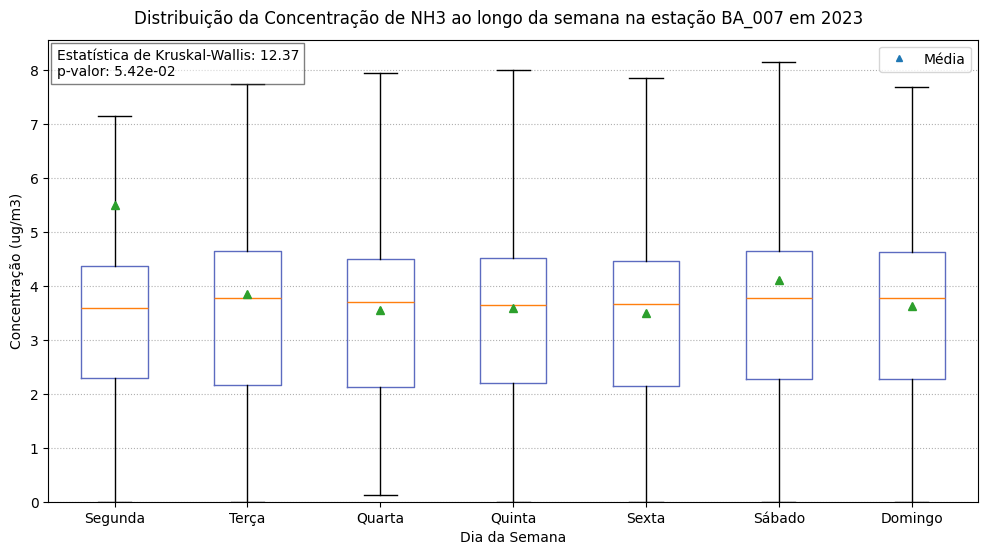

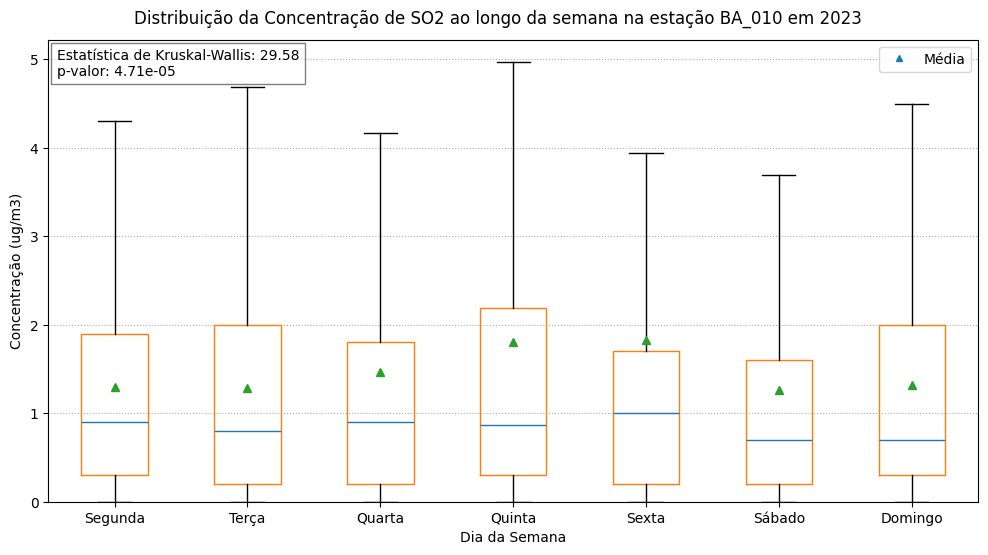

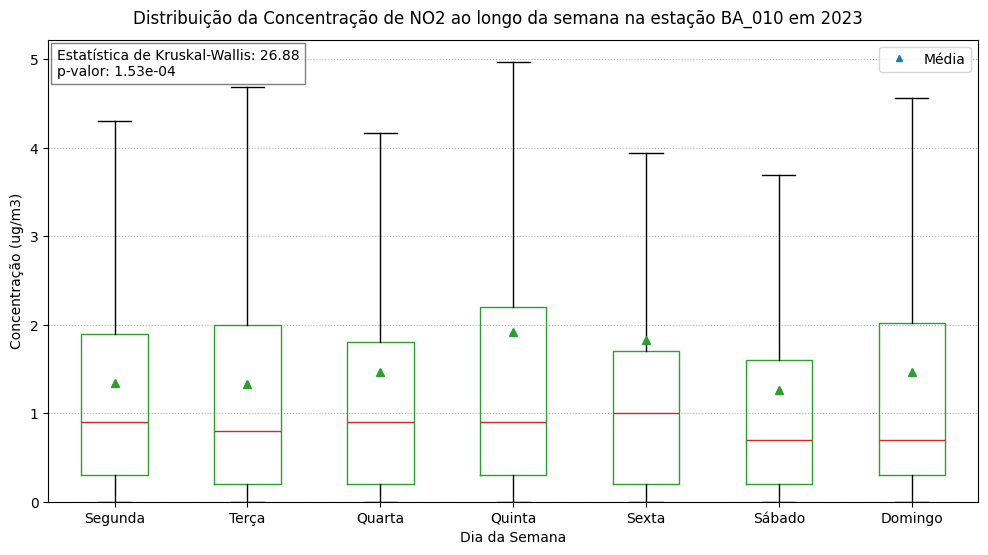

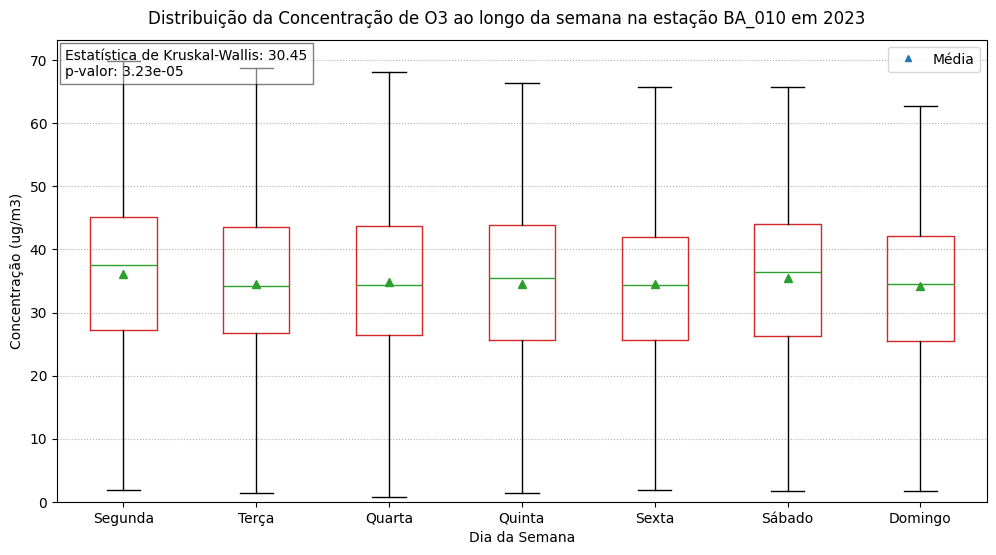

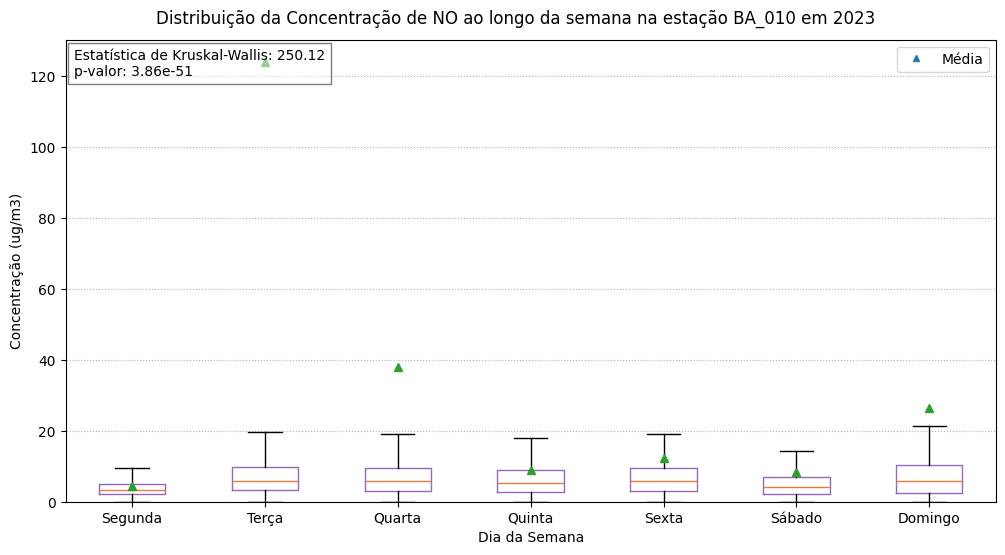

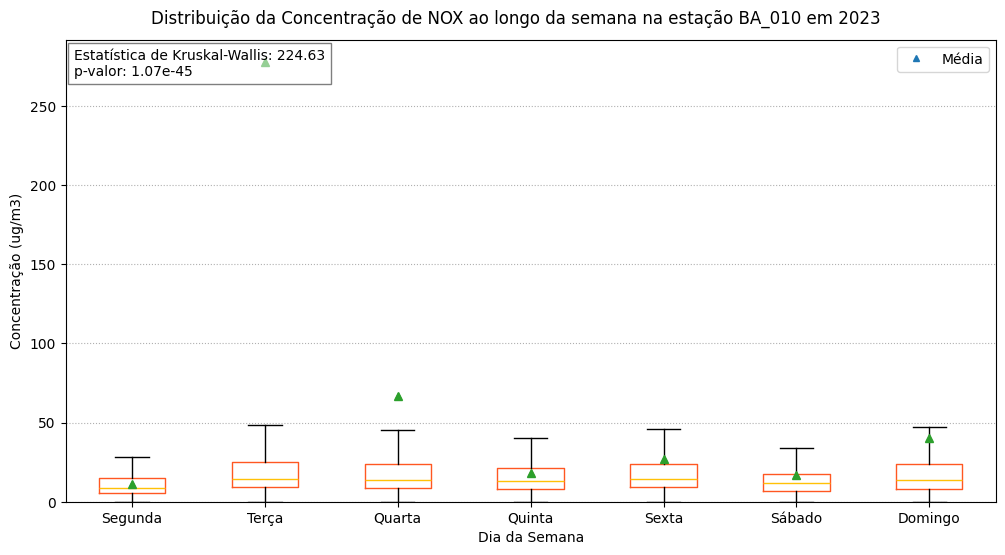

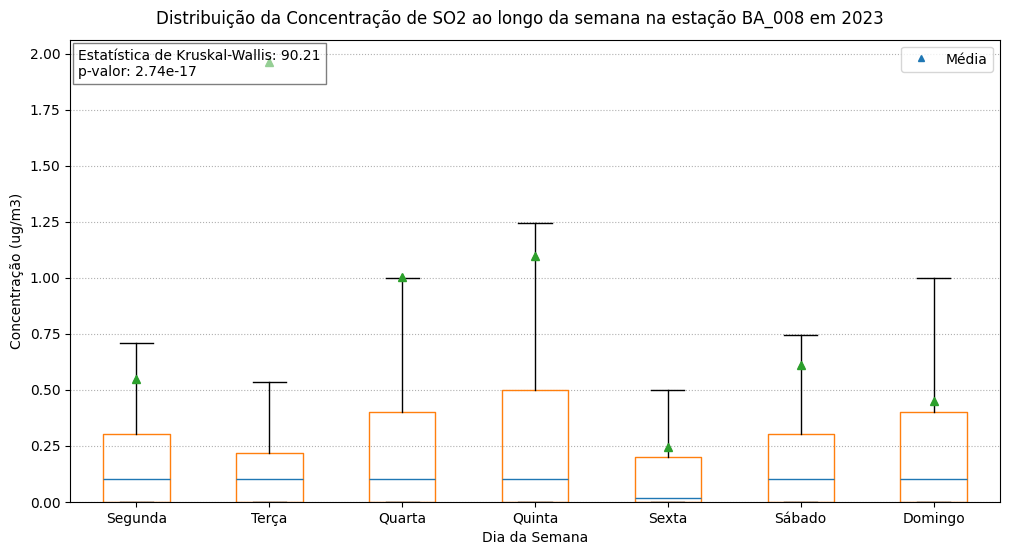

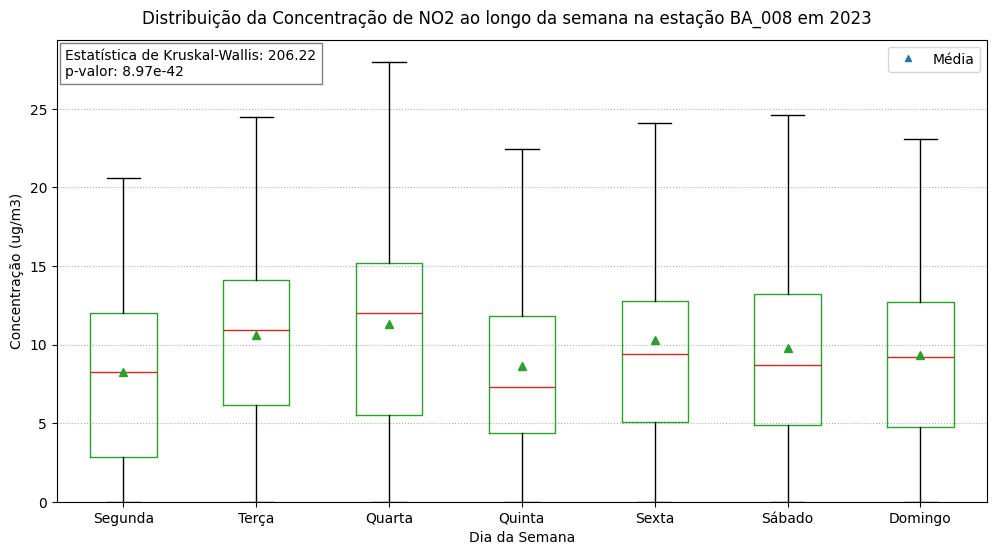

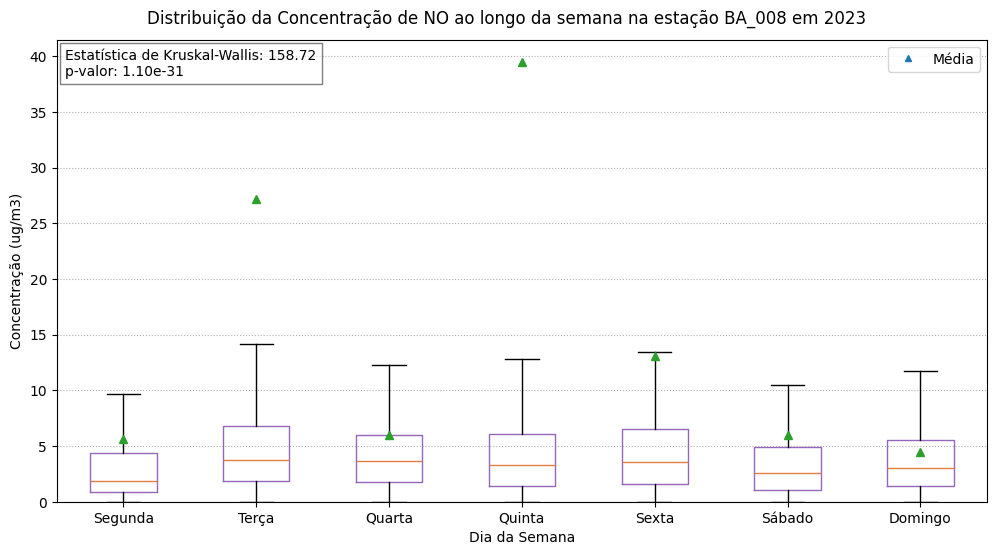

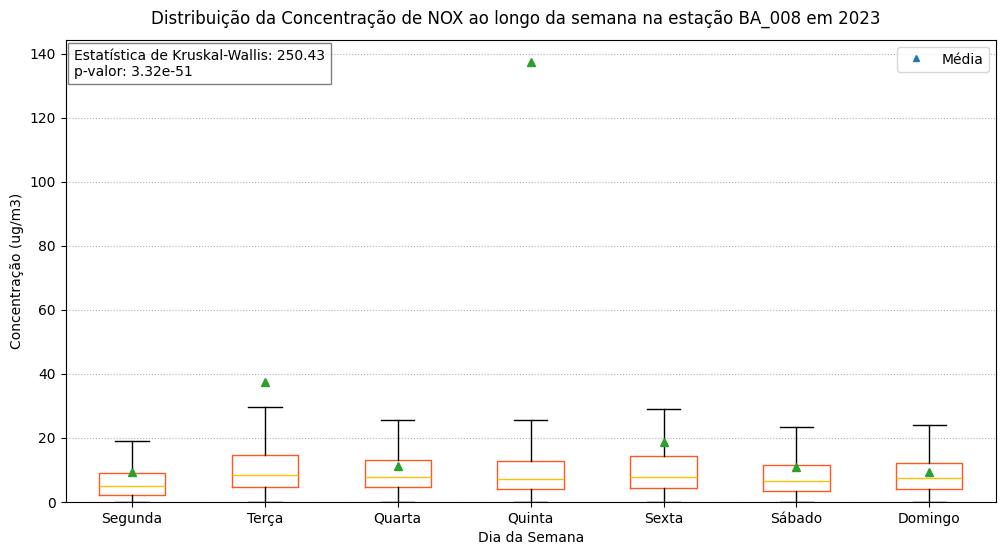

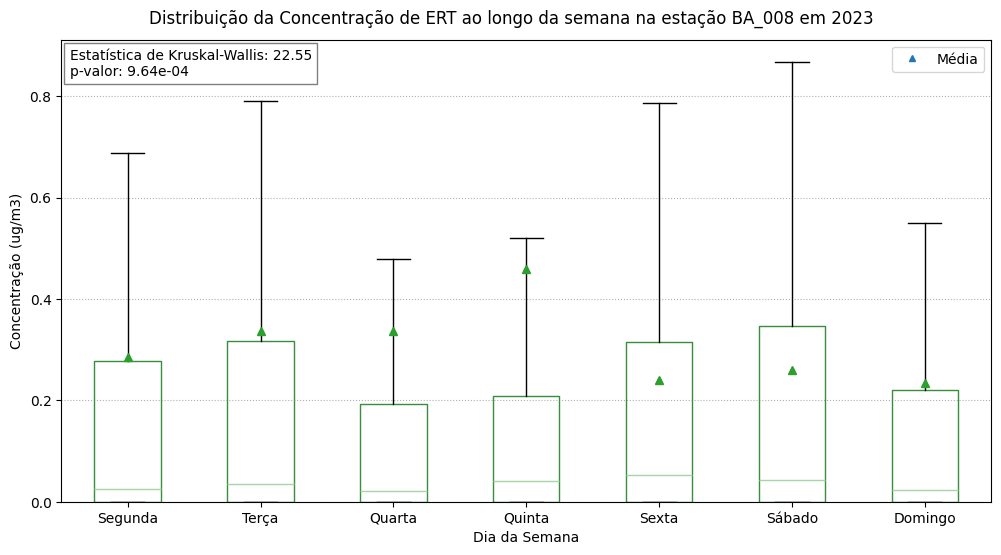

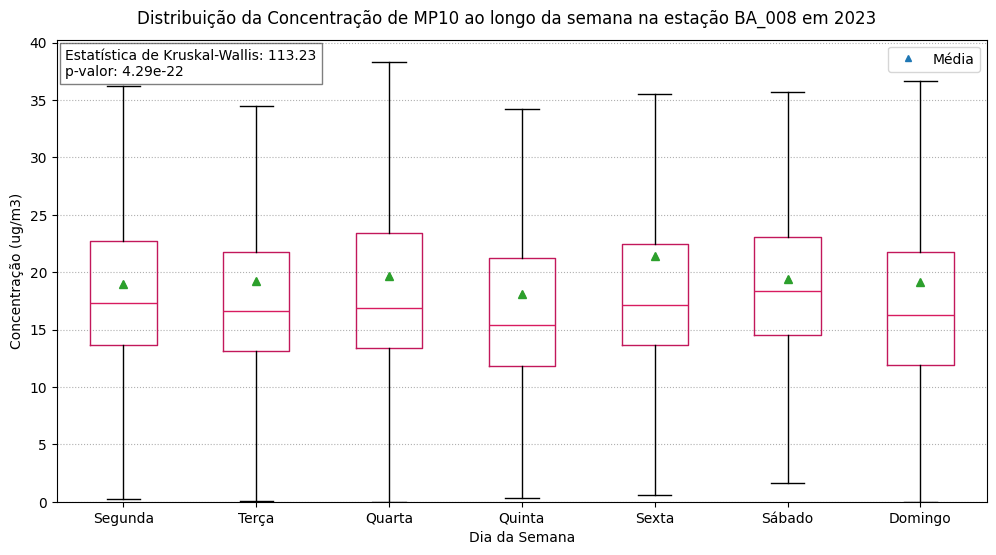

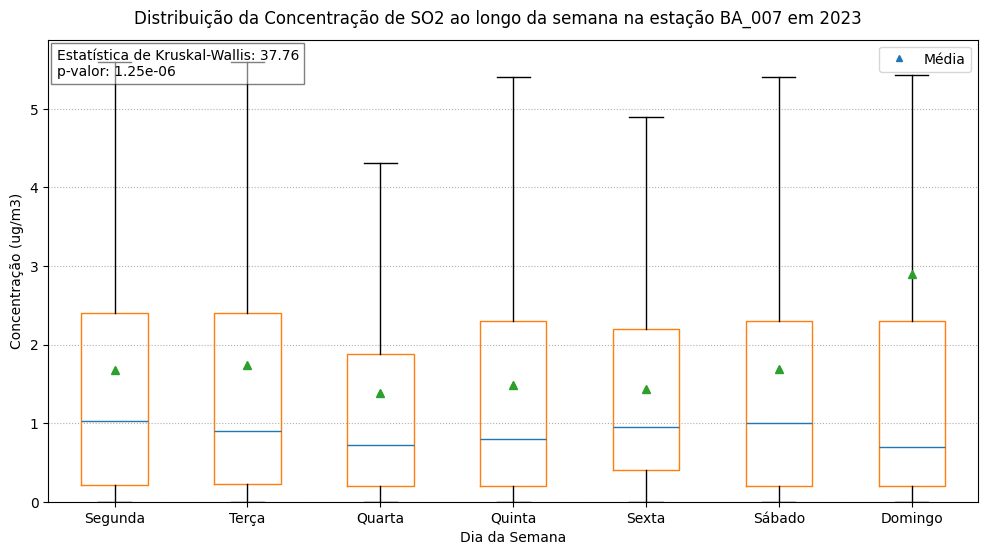

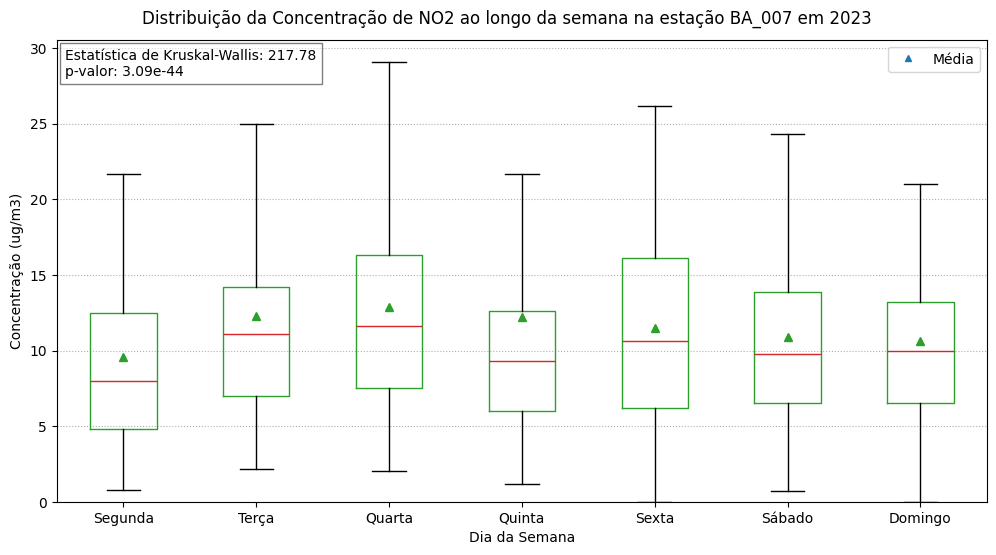

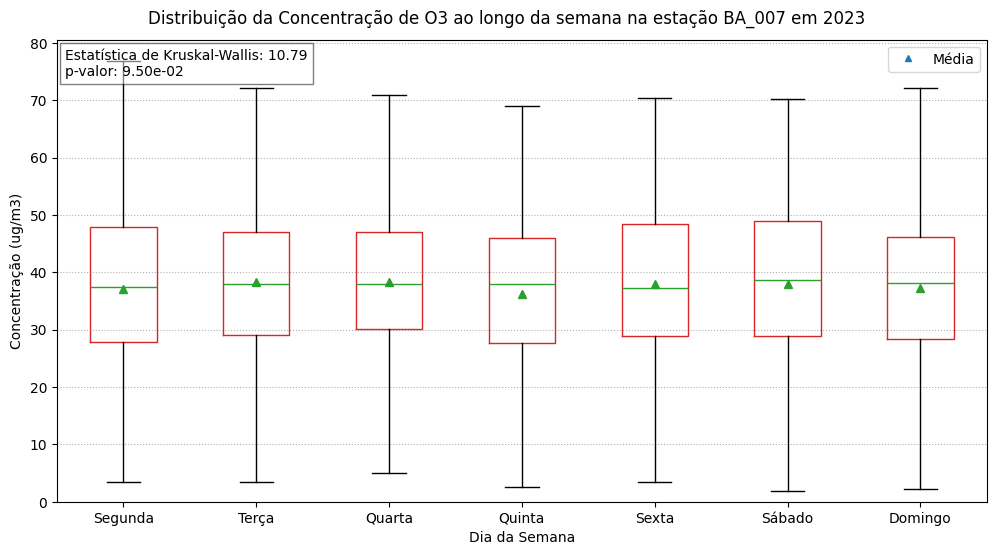

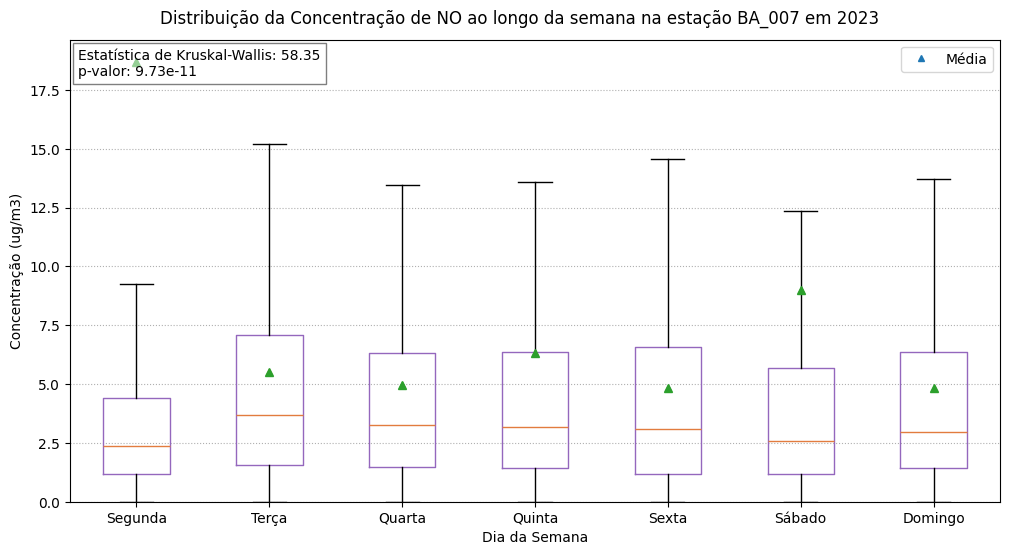

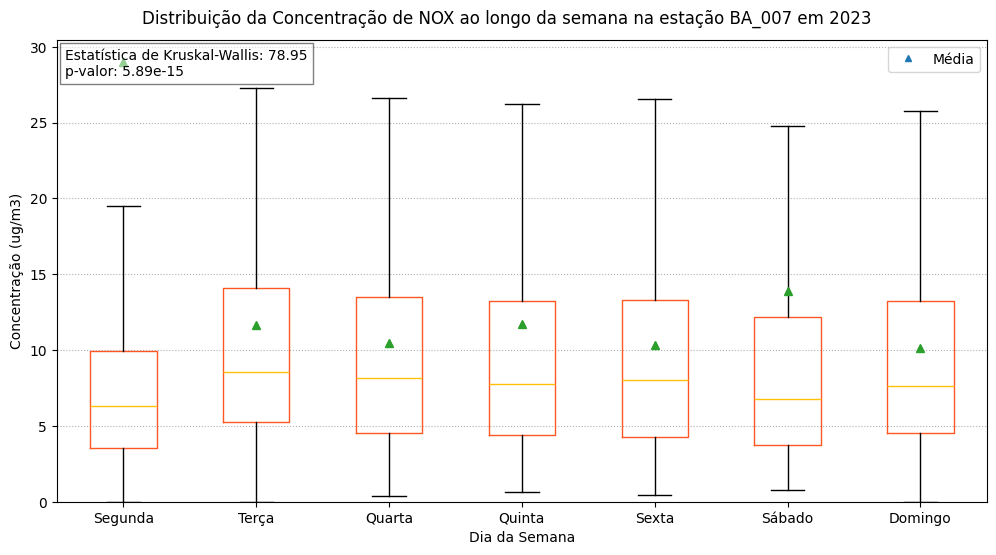

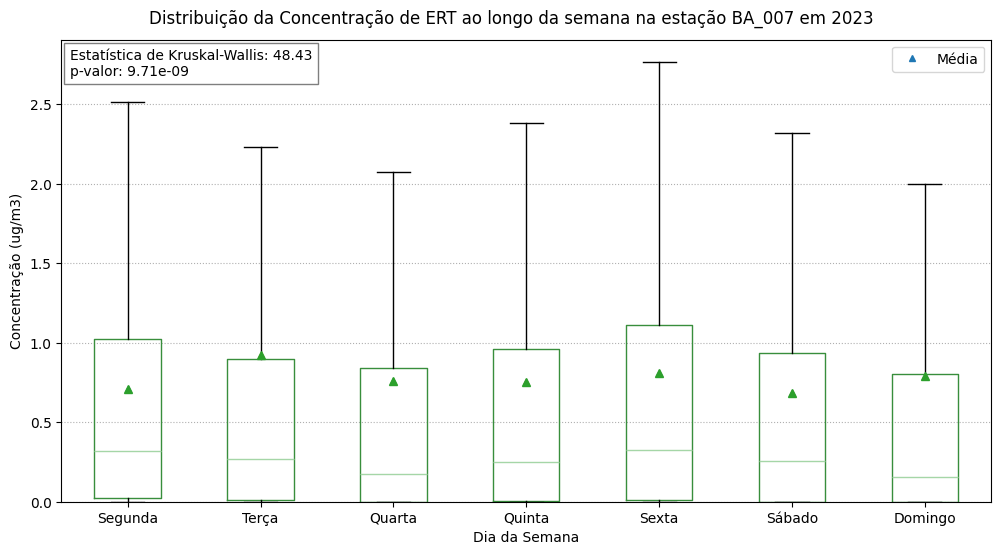

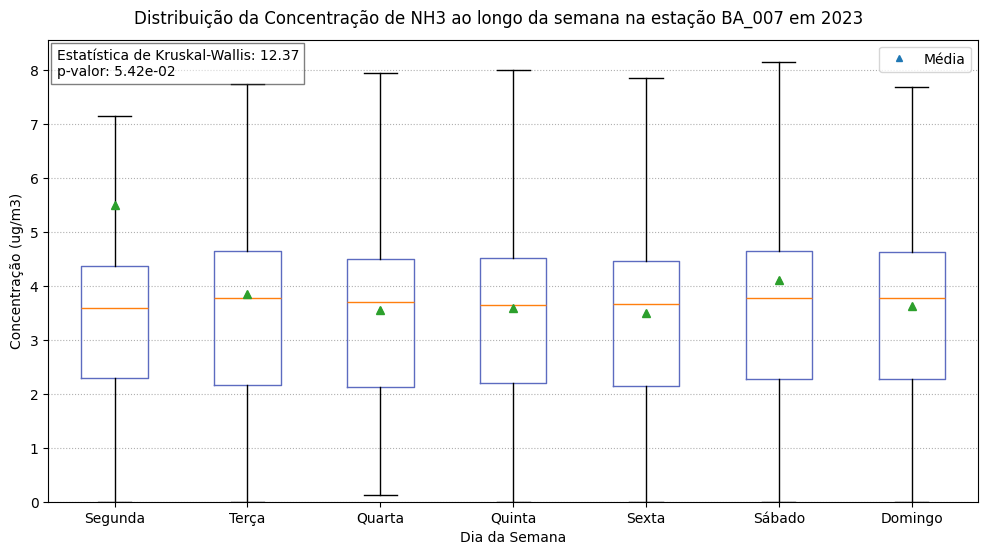

In [82]:
statisticsAndFigures_weekday('BA_2023.csv')